# DRINKING WATER
This notebook will be used to measure indicators for EDGI/EEW's 'state of the environment report.'
It is based on the NJ SDWA EJ notebook and the SOE report notebooks for other environmental media/pollutants.

In [1]:
# import libraries
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

# Load Facilities Data

This section creates a dataframe of basic information about **active** water systems 


There is an option to filter for only Community Water Systems (or any other type) 

In [2]:
# Load facilities data into notebook
path = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\sdwa\SDWA_latest_downloads\SDWA_PUB_WATER_SYSTEMS.csv"
sdwa_pws = pd.read_csv(path)

C:\Users\jenni\AppData\Local\Temp\ipykernel_30104\815436955.py:3: DtypeWarning: Columns (11,30,32,33,34,43,44,45,46,47,48,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  sdwa_pws = pd.read_csv(path)


In [3]:
# Filter to include only active systems
print("Number of systems total:",(len(sdwa_pws)))
sdwa_pws_active = sdwa_pws[sdwa_pws['PWS_ACTIVITY_CODE'] == 'A']
# total number of active PWS
print("Number of active systems:",(len(sdwa_pws_active)))

Number of systems total: 431754
Number of active systems: 143385


In [4]:
# summarize active PWS by type
sdwa_pws_active['PWS_TYPE_CODE'].value_counts()

PWS_TYPE_CODE
TNCWS     76822
CWS       49413
NTNCWS    17150
Name: count, dtype: int64

Filter to include only certain system types here >>>

In [5]:
#sdwa_pws_active = sdwa_pws_active[sdwa_pws_active['PWS_TYPE_CODE'] == 'CWS']
#print("Number of systems after filtering:",(len(sdwa_pws_active)))

# Load and Prep Violations Data

This section imports violations data (select columns), cleans up date fields, maps field codes, cleans up the state code field, and joins violations data to the facilities df

In [6]:
# Load Violations data into notebook
# File is too large to load in entirety so only load selected columns
path = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\sdwa\SDWA_latest_downloads\SDWA_VIOLATIONS_ENFORCEMENT.csv"
sdwa_viols = pd.read_csv(path,
                         usecols=['PWSID', 
                                  'VIOLATION_ID', 
                                  'VIOLATION_CODE',
                                  'VIOLATION_CATEGORY_CODE', 
                                  'IS_HEALTH_BASED_IND',
                                  'CONTAMINANT_CODE', 
                                  'RULE_CODE',
                                  'NON_COMPL_PER_BEGIN_DATE', 
                                  'NON_COMPL_PER_END_DATE',
                                  'VIOL_FIRST_REPORTED_DATE', 
                                  'ENFORCEMENT_ID',
                                  'ENFORCEMENT_DATE', 
                                  'ENFORCEMENT_ACTION_TYPE_CODE',
                                  'ENF_ACTION_CATEGORY', 
                                  'ENF_ORIGINATOR_CODE',
                                  'VIOLATION_STATUS'
                                 ],
                         parse_dates=['NON_COMPL_PER_BEGIN_DATE', 
                                      'NON_COMPL_PER_END_DATE', 
                                      'VIOL_FIRST_REPORTED_DATE', 
                                      'ENFORCEMENT_DATE'
                                     ]
                        )
print(len(sdwa_viols))

C:\Users\jenni\AppData\Local\Temp\ipykernel_30104\3807560092.py:4: DtypeWarning: Columns (1,2,9,10,11,12,20,31,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  sdwa_viols = pd.read_csv(path,


14665006


## This section fixes some typing problems and data entry anomalies in the date fields

In [7]:
# Check date fields for null values
print("Number of records with Null NON_COMPL_PER_BEGIN_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].isna()]==True)))
print("Number of records with Null NON_COMPL_PER_END_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)))
print("Number of records with Null VIOL_FIRST_REPORTED_DATE = " + str(len(sdwa_viols[sdwa_viols['VIOL_FIRST_REPORTED_DATE'].isna()]==True)))
#print("Number of records with Null VIOL_LAST_REPORTED_DATE = " + str(len(sdwa_viols[sdwa_viols['VIOL_LAST_REPORTED_DATE'].isna()]==True)))
print("Number of records with Null ENFORCEMENT_DATE = " + str(len(sdwa_viols[sdwa_viols['ENFORCEMENT_DATE'].isna()]==True)))
#print("Number of records with Null ENF_FIRST_REPORTED_DATE = " + str(len(sdwa_viols[sdwa_viols['ENF_FIRST_REPORTED_DATE'].isna()]==True)))
#print("Number of records with Null ENF_LAST_REPORTED_DATE = " + str(len(sdwa_viols[sdwa_viols['ENF_LAST_REPORTED_DATE'].isna()]==True)))

Number of records with Null NON_COMPL_PER_BEGIN_DATE = 998473
Number of records with Null NON_COMPL_PER_END_DATE = 998473
Number of records with Null VIOL_FIRST_REPORTED_DATE = 998482
Number of records with Null ENFORCEMENT_DATE = 489461


In [8]:
# Check date field formats
print(type(sdwa_viols['NON_COMPL_PER_END_DATE'].loc[1]))
print(type(sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].loc[1]))
print(type(sdwa_viols['VIOL_FIRST_REPORTED_DATE'].loc[1]))
#print(type(sdwa_viols['VIOL_LAST_REPORTED_DATE'].loc[1]))
print(type(sdwa_viols['ENFORCEMENT_DATE'].loc[1]))
#print(type(sdwa_viols['ENF_FIRST_REPORTED_DATE'].loc[1]))
#print(type(sdwa_viols['ENF_LAST_REPORTED_DATE'].loc[1]))

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [9]:
# NON_COMPL_PER_END_DATE did not convert to timestamp
# why? some rows contain arrows; what do these mean?!?
sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE']=='--->']

,PWSID,VIOLATION_ID,NON_COMPL_PER_BEGIN_DATE,NON_COMPL_PER_END_DATE,VIOLATION_CODE,VIOLATION_CATEGORY_CODE,IS_HEALTH_BASED_IND,CONTAMINANT_CODE,VIOLATION_STATUS,RULE_CODE,VIOL_FIRST_REPORTED_DATE,ENFORCEMENT_ID,ENFORCEMENT_DATE,ENFORCEMENT_ACTION_TYPE_CODE,ENF_ACTION_CATEGORY,ENF_ORIGINATOR_CODE
231,10307001,0307001343014122015,2015-12-01,--->,34,MR,N,3014.0,Unaddressed,140.0,2024-10-07,0307001IA04011622810,2016-04-01,EIA,Informal,R
232,10307001,0307001343014122015,2015-12-01,--->,34,MR,N,3014.0,Unaddressed,140.0,2024-10-07,0307001IE04011622812,2016-04-01,EIE,Informal,R
233,10307001,0307001343014122015,2015-12-01,--->,34,MR,N,3014.0,Unaddressed,140.0,2024-10-07,0307001IF06301622814,2016-06-30,EIF,Informal,R
234,10307001,030700134301462016,2016-06-01,--->,34,MR,N,3014.0,Unaddressed,140.0,2024-10-07,0307001IA10311622825,2016-10-31,EIA,Informal,R
235,10307001,030700134301462016,2016-06-01,--->,34,MR,N,3014.0,Unaddressed,140.0,2024-10-07,0307001IE10311622826,2016-10-31,EIE,Informal,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13666514,PA2520092,2322080,2023-04-11,--->,75,Other,N,7500.0,Unaddressed,410.0,2023-06-15,NaN,NaT,NaN,NaN,NaN
13666515,PA2520092,2400802,2023-10-11,--->,75,Other,N,7500.0,Unaddressed,410.0,2024-02-23,NaN,NaT,NaN,NaN,NaN
13666519,PA2520091,2300441,2022-10-11,--->,75,Other,N,7500.0,Unaddressed,410.0,2023-02-15,NaN,NaT,NaN,NaN,NaN
13666525,PA2520092,2314007,2023-01-11,--->,75,Other,N,7500.0,Unaddressed,410.0,2023-03-16,NaN,NaT,NaN,NaN,NaN


In [10]:
# could the arrows indicate open violations but are incorrectly formatted? 
# data dictionary says open violations have NON_COMPL_PER_END_DATE = null
print("Number of records with Null NON_COMPL_PER_END_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)))

Number of records with Null NON_COMPL_PER_END_DATE = 998473


In [11]:
# when did these null (open?) violations begin?
sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()==True]['NON_COMPL_PER_BEGIN_DATE']

13666533   NaT
13666534   NaT
13666535   NaT
13666536   NaT
13666537   NaT
            ..
14665001   NaT
14665002   NaT
14665003   NaT
14665004   NaT
14665005   NaT
Name: NON_COMPL_PER_BEGIN_DATE, Length: 998473, dtype: datetime64[ns]

In [12]:
# violations with NON_COMPL_PER_END_DATE = null (supposed to be open violations) do not seem to have begin dates either
# check how many records have null NON_COMPL_PER_END_DATE that have a valid NON_COMPL_PER_BEGIN_DATE
sdwa_viols[(sdwa_viols['NON_COMPL_PER_END_DATE'].isna()==True) & (sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].isna()==False)]

,PWSID,VIOLATION_ID,NON_COMPL_PER_BEGIN_DATE,NON_COMPL_PER_END_DATE,VIOLATION_CODE,VIOLATION_CATEGORY_CODE,IS_HEALTH_BASED_IND,CONTAMINANT_CODE,VIOLATION_STATUS,RULE_CODE,VIOL_FIRST_REPORTED_DATE,ENFORCEMENT_ID,ENFORCEMENT_DATE,ENFORCEMENT_ACTION_TYPE_CODE,ENF_ACTION_CATEGORY,ENF_ORIGINATOR_CODE


In [13]:
# that's an empty dataframe
# how many records have null NON_COMPL_PER_BEGIN_DATE & how many have null NON_COMPL_PER_END_DATE?
print("Number of records with Null NON_COMPL_PER_BEGIN_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].isna()]==True)))
print("Number of records with Null NON_COMPL_PER_END_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)))

Number of records with Null NON_COMPL_PER_BEGIN_DATE = 998473
Number of records with Null NON_COMPL_PER_END_DATE = 998473


In [14]:
# same exact number of records 
# seems like the data coding for open violations is incorrect; instead of null they used arrows
# when do the violations with arrow notations for NON_COMPL_PER_END_DATE occur?
sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'] == '--->']['NON_COMPL_PER_BEGIN_DATE']

231        2015-12-01
232        2015-12-01
233        2015-12-01
234        2016-06-01
235        2016-06-01
              ...    
13666514   2023-04-11
13666515   2023-10-11
13666519   2022-10-11
13666525   2023-01-11
13666528   2024-04-11
Name: NON_COMPL_PER_BEGIN_DATE, Length: 81239, dtype: datetime64[ns]

In [15]:
# most of the 81,239 rows with arrows are pre-2024
# will assume these are open violations
# what to do about the arrow notation? need to convert this field from string to date so that i can do calculations with the NON_COMPL_PER_END_DATE field
# can't do that with the arrows there
# replace arrows with a null value
sdwa_viols['NON_COMPL_PER_END_DATE'] = sdwa_viols['NON_COMPL_PER_END_DATE'].replace('--->',pd.NaT)

In [16]:
# now how many records with NON_COMPL_PER_END_DATE null?
print("Number of records with Null NON_COMPL_PER_END_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)))

Number of records with Null NON_COMPL_PER_END_DATE = 1079712


In [17]:
# how many records have null NON_COMPL_PER_END_DATE & also null NON_COMPL_PER_BEGIN_DATE?
print(len(sdwa_viols[(sdwa_viols['NON_COMPL_PER_END_DATE'].isna()==True) & (sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].isna()==True)]))

998473


In [18]:
# i've replaced the open violation arrow notation with a null value for those records with a valid NON_COMPL_PER_BEGIN_DATE
# still have 998,473 records missing non-compliance date data
# can't address those

In [19]:
# convert NON_COMPL_PER_END_DATE to datetime 
sdwa_viols['NON_COMPL_PER_END_DATE'] = pd.to_datetime(sdwa_viols['NON_COMPL_PER_END_DATE'], format='mixed')
print(type(sdwa_viols['NON_COMPL_PER_END_DATE'].loc[1]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


### Now it is possible to filter with and calculate dates (more) accurately

In [20]:
# Filter violations to those occurring from 2001-2023
sdwa_viols = sdwa_viols[(sdwa_viols['NON_COMPL_PER_BEGIN_DATE']>'12-31-2000') & (sdwa_viols['NON_COMPL_PER_BEGIN_DATE']<'01-01-2024')]
print("There are",(len(sdwa_viols)),"violations from 2001-2023")

There are 10042110 violations from 2001-2023


In [21]:
# how many open violations are there in this time period?
print("There are " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)) + " open violations from 2001-2023")

There are 63532 open violations from 2001-2023


In [22]:
# Merge violations data with active PWS list 
pws_viols = sdwa_viols.merge(sdwa_pws_active, left_on='PWSID', right_on='PWSID')

In [23]:
# how many open violations are there for active pws?
print("There are " + str(len(pws_viols[pws_viols['NON_COMPL_PER_END_DATE'].isna()]==True)) + " open violations from 2001-2023")

There are 63252 open violations from 2001-2023


In [24]:
# create a column in the df to store just the year of the non compliance date
pws_viols['Year'] = pws_viols['NON_COMPL_PER_BEGIN_DATE'].dt.year 

In [25]:
# create a column in the df to store the duration of noncompliance using the non-compliance begin/end fields
pws_viols['non_compl_duration'] = pws_viols['NON_COMPL_PER_END_DATE'] - pws_viols['NON_COMPL_PER_BEGIN_DATE']

In [26]:
# how have the open violation durations been recorded?
pws_viols[pws_viols['NON_COMPL_PER_END_DATE'].isna()==True]['non_compl_duration']

7216      NaT
15173     NaT
15174     NaT
15175     NaT
15176     NaT
           ..
7609245   NaT
7609250   NaT
7609251   NaT
7609253   NaT
7609254   NaT
Name: non_compl_duration, Length: 63252, dtype: timedelta64[ns]

In [27]:
print("The dataset includes",len(pws_viols),"violations")
pws_viols.head()

The dataset includes 7609255 violations


,PWSID,VIOLATION_ID,NON_COMPL_PER_BEGIN_DATE,NON_COMPL_PER_END_DATE,VIOLATION_CODE,VIOLATION_CATEGORY_CODE,IS_HEALTH_BASED_IND,CONTAMINANT_CODE,VIOLATION_STATUS,RULE_CODE,...,SOURCE_WATER_PROTECTION_CODE,SOURCE_PROTECTION_BEGIN_DATE,OUTSTANDING_PERFORMER,OUTSTANDING_PERFORM_BEGIN_DATE,REDUCED_RTCR_MONITORING,REDUCED_MONITORING_BEGIN_DATE,REDUCED_MONITORING_END_DATE,SEASONAL_STARTUP_SYSTEM,Year,non_compl_duration
0,105314113,0120007,2001-01-01,2001-01-31,22,MCL,Y,3100.0,Archived,110.0,...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,30 days
1,105314113,0130056,2001-06-01,2001-06-30,22,MCL,Y,3100.0,Archived,110.0,...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,29 days
2,105314113,0130057,2001-07-01,2002-09-30,71,Other,N,7000.0,Resolved,420.0,...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,456 days
3,105314113,0130057,2001-07-01,2002-09-30,71,Other,N,7000.0,Resolved,420.0,...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,456 days
4,105314113,0130057,2001-07-01,2002-09-30,71,Other,N,7000.0,Resolved,420.0,...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,456 days


## Map the field descriptions for data codes using the data dictionary

In [28]:
# Read ref codes dictionary
path = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\sdwa\SDWA_latest_downloads\SDWA_REF_CODE_VALUES.csv"
sdwa_ref_codes = pd.read_csv(path)

# violation codes
violations = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='VIOLATION_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['VIOLATION_CODE'] = pws_viols['VIOLATION_CODE'].astype(str).map(violations)

# violation category codes
violation_categories = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='VIOLATION_CATEGORY_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['VIOLATION_CATEGORY_CODE'] = pws_viols['VIOLATION_CATEGORY_CODE'].astype(str).map(violation_categories)

# rule codes
rules = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='RULE_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['RULE_CODE'] = pws_viols['RULE_CODE'].astype(int).astype(str).map(rules) # some of these imported as floats so have to convert to int then string to avoid losing data

# contaminant codes
# note: There are no NaNs in the contaminant codes field in the imported data but after mapping there are 47 NaNs
contaminants = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='CONTAMINANT_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['CONTAMINANT_CODE'] = pws_viols['CONTAMINANT_CODE'].dropna().astype(str).map(contaminants) # some of these imported as floats so have to convert to int then string to avoid losing data

# enforcement action type codes
enforcement_action_types = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='ENFORCEMENT_ACTION_TYPE_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['ENFORCEMENT_ACTION_TYPE_CODE'] = pws_viols['ENFORCEMENT_ACTION_TYPE_CODE'].astype(str).map(enforcement_action_types)

### Clean up state codes

In [29]:
# see the list of STATE_CODE values
pws_viols['STATE_CODE'].unique()

array(['WA', 'OR', 'AK', 'UT', 'CA', 'CO', 'CT', 'BC', 'ID', 'TX', 'PA',
       'AL', 'MS', 'TN', 'GA', 'AR', 'MO', 'NC', 'NM', 'MN', 'LA', 'AS',
       'AZ', 'AB', 'MA', 'IN', 'NV', 'OK', 'VA', 'MI', 'FL', nan, 'KS',
       'IA', 'MT', 'NE', 'ME', 'IL', 'NY', 'OH', 'KY', 'WY', 'WI', 'NH',
       'RI', 'NJ', 'DC', 'DE', 'MD', 'SC', 'GU', 'AP', 'HI', 'WV', 'SD',
       'VT', 'ON', 'ND', 'MP', 'PR', 'VI', 'PQ', 'QC'], dtype=object)

In [30]:
# list of valid state and territory codes
# https://pe.usps.com/text/pub28/28apb.htm
usps_codes = ['AL', 'AK', 'AS', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 
              'FM', 'FL', 'GA', 'GU', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 
              'KY', 'LA', 'ME', 'MH', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 
              'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'MP', 
              'OH', 'OK', 'OR', 'PW', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 
              'TX', 'UT', 'VT', 'VI', 'VA', 'WA', 'WV', 'WI', 'WY']

In [31]:
# for violations not in the state code list, what are the pwsid's 
pws_viols[pws_viols['STATE_CODE'].isin(usps_codes)==False][['PWSID','STATE_CODE']]

,PWSID,STATE_CODE
20889,AK2242953,BC
20890,AK2242953,BC
20891,AK2242953,BC
152259,AZ0407518,AB
152260,AZ0407518,AB
...,...,...
7608465,WY5600221,NaN
7608592,WA5389080,NaN
7608754,WA5389080,NaN
7609162,WA5389080,NaN


In [32]:
# there are 10,941 violations without a valid state code
# 5348 of those are CWS
# Can the pwsid's be used to replace the invalid STATE_CODE data? (They usually start with the state code)
# check the whole set of pwsid's that don't match state code
pws_viols[pws_viols['STATE_CODE'] != pws_viols['PWSID'].str.slice(start=0, stop=2)][['PWSID', 'STATE_CODE']]

,PWSID,STATE_CODE
0,105314113,WA
1,105314113,WA
2,105314113,WA
3,105314113,WA
4,105314113,WA
...,...,...
7609171,VI0000421,NaN
7609192,105300015,WA
7609216,VT0008350,MA
7609219,WA5302217,OR


In [33]:
# It looks like valid state codes often don't match the beginning of the pwsid
# there are 10,941 invalid state codes; that's a relatively small part of the dataset
# drop the data with invalid state codes; don't want to make assumptions about these locations
pws_viols = pws_viols[pws_viols['STATE_CODE'].isin(usps_codes)==True]

## Filter for Health-Based Violations

In [34]:
print("The dataset includes",len(pws_viols),"violations at",len(pws_viols['PWSID'].unique()),"water systems")
print("The average number of violations per year is",int((len(pws_viols) / 23)))

The dataset includes 7598314 violations at 117080 water systems
The average number of violations per year is 330361


In [35]:
# create df of active pws, health viols only
pws_viols_health = pws_viols[pws_viols['IS_HEALTH_BASED_IND']=='Y']
print("The dataset includes",len(pws_viols_health),"health-based violations at",len(pws_viols_health['PWSID'].unique()),"water systems")
print("The average number of health_based violations per year is",int((len(pws_viols_health) / 23)))

The dataset includes 1160078 health-based violations at 60725 water systems
The average number of health_based violations per year is 50438


In [36]:
# create a series of the number of health violations per year, for later use
num_viols_health = pws_viols_health.groupby(['Year']).count().rename(columns={'VIOLATION_ID':'num_viols_tot_yr'})['num_viols_tot_yr']

# Violations Data Analysis

## Number of violations per year

Text(11.472222222222216, 0.5, 'Number of Violations')

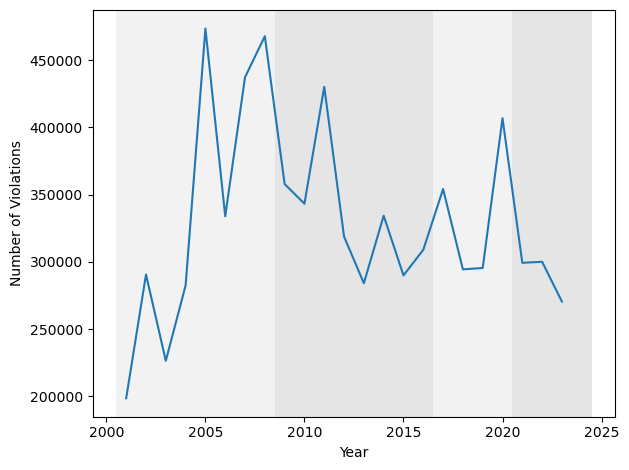

In [37]:
# make a plot of violations by year
sns.lineplot(data=pws_viols.groupby(['Year']).count(), x='Year', y='VIOLATION_ID')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.ylabel('Number of Violations')
#plt.savefig('num_viols_by_year.png')

## Type of violations by year

In [38]:
# group violations by type and year
pws_viols_type = pws_viols.groupby(['Year', 'VIOLATION_CATEGORY_CODE'], as_index=False)[['VIOLATION_ID']].count()
pws_viols_type

,Year,VIOLATION_CATEGORY_CODE,VIOLATION_ID
0,2001,Maximum Contaminant Level Violation,26156
1,2001,Monitoring and Reporting,158675
2,2001,Other Violation,10465
3,2001,Treatment Technique Violation,3201
4,2002,Maximum Contaminant Level Violation,28900
...,...,...,...
127,2023,Monitoring Violation,61118
128,2023,Monitoring and Reporting,137918
129,2023,Other Violation,29303
130,2023,Reporting Violation,6452


In [39]:
# make an array of the violation types
viol_types = pws_viols_type['VIOLATION_CATEGORY_CODE'].unique()
viol_types

array(['Maximum Contaminant Level Violation', 'Monitoring and Reporting',
       'Other Violation', 'Treatment Technique Violation',
       'Maximum Residual Disinfectant Level', 'Monitoring Violation',
       'Reporting Violation'], dtype=object)

In [40]:
# there are 7 violation types but they aren't consistent over the years
# create a dictionary of violation categories with values over the years
viol_counts = dict()
for viol_type in viol_types:
    array = np.array(pws_viols_type[pws_viols_type['VIOLATION_CATEGORY_CODE'] == viol_type]['VIOLATION_ID'])
    viol_counts.update({viol_type: array})
viol_counts

{'Maximum Contaminant Level Violation': array([26156, 28900, 33273, 41039, 55188, 57034, 59472, 59804, 57295,
        55285, 53553, 50664, 49350, 51307, 55253, 35976, 31455, 30455,
        30229, 26363, 24161, 23594, 21648]),
 'Monitoring and Reporting': array([158675, 242691, 168075, 215103, 389353, 249223, 347742, 378727,
        272279, 259053, 346777, 234837, 205632, 251493, 199587, 169229,
        212944, 156890, 159587, 277213, 166470, 166594, 137918]),
 'Other Violation': array([10465, 15746, 20972, 21216, 21751, 20023, 23373, 24020, 23553,
        23633, 23926, 27181, 22669, 24207, 25050, 32728, 27714, 24329,
        24346, 25155, 25338, 25883, 29303]),
 'Treatment Technique Violation': array([ 3201,  3209,  4034,  4991,  7242,  7620,  6764,  5291,  4686,
         5264,  5917,  6055,  6416,  7257,  9178, 14561, 14580, 15583,
        15358, 11921, 14147, 14368, 13914]),
 'Maximum Residual Disinfectant Level': array([  4,   3,  62,  73,   6,   6,  31,  26,  22,  31,   8,   9,  42

Text(0, 0.5, 'Number of Violations')

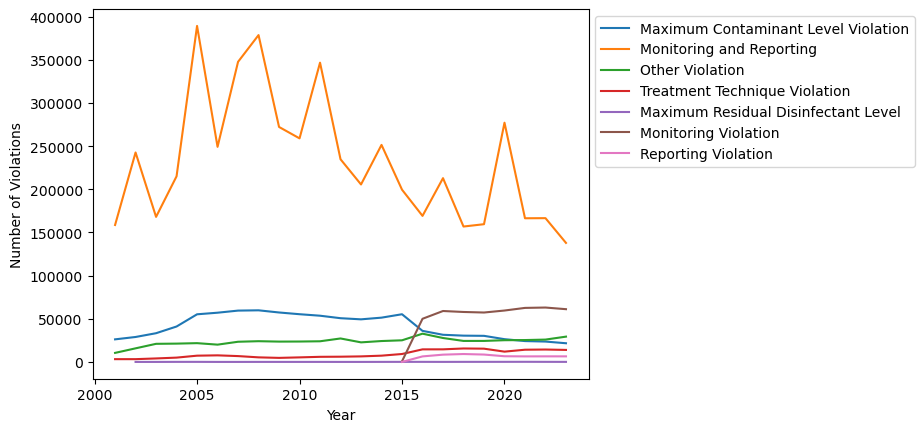

In [41]:
# take a look at the change over time
sns.lineplot(data=pws_viols_type, x='Year', y='VIOLATION_ID', hue='VIOLATION_CATEGORY_CODE')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Number of Violations')

In [42]:
# maximum residual disinfectant level appears in 2002 and is consistently negligibly low
# in 2015 monitoring and reporting violation categories appear
# the monitoring category is a relatively low but non-negligible number
# lump these 2 categories with the M&R category

In [43]:
# map the new category values
# use a copy of the pws_viols df because I'm about to drop data and also not sure the significance of the M&R coding
pws_viols_copy = pws_viols.copy(deep=True) # this is a deep copy
pws_viols_copy = pws_viols_copy.replace(['Monitoring Violation','Reporting Violation'],['Monitoring and Reporting','Monitoring and Reporting'])
viol_types = pws_viols_copy['VIOLATION_CATEGORY_CODE'].unique()
viol_types

C:\Users\jenni\AppData\Local\Temp\ipykernel_30104\2076428083.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pws_viols_copy = pws_viols_copy.replace(['Monitoring Violation','Reporting Violation'],['Monitoring and Reporting','Monitoring and Reporting'])


array(['Maximum Contaminant Level Violation', 'Other Violation',
       'Monitoring and Reporting', 'Treatment Technique Violation',
       'Maximum Residual Disinfectant Level'], dtype=object)

In [44]:
# regroup violations by type and year
pws_viols_type = pws_viols_copy.groupby(['Year', 'VIOLATION_CATEGORY_CODE'], as_index=False)[['VIOLATION_ID']].count()

In [45]:
# new dictionary of violation counts
viol_counts = dict()
for viol_type in viol_types:
    array = np.array(pws_viols_type[pws_viols_type['VIOLATION_CATEGORY_CODE'] == viol_type]['VIOLATION_ID'])
    viol_counts.update({viol_type: array})
viol_counts

{'Maximum Contaminant Level Violation': array([26156, 28900, 33273, 41039, 55188, 57034, 59472, 59804, 57295,
        55285, 53553, 50664, 49350, 51307, 55253, 35976, 31455, 30455,
        30229, 26363, 24161, 23594, 21648]),
 'Other Violation': array([10465, 15746, 20972, 21216, 21751, 20023, 23373, 24020, 23553,
        23633, 23926, 27181, 22669, 24207, 25050, 32728, 27714, 24329,
        24346, 25155, 25338, 25883, 29303]),
 'Monitoring and Reporting': array([158675, 242691, 168075, 215103, 389353, 249223, 347742, 378727,
        272279, 259053, 346777, 234837, 205632, 251493, 200311, 225616,
        280364, 223925, 225382, 343348, 235484, 236077, 205488]),
 'Treatment Technique Violation': array([ 3201,  3209,  4034,  4991,  7242,  7620,  6764,  5291,  4686,
         5264,  5917,  6055,  6416,  7257,  9178, 14561, 14580, 15583,
        15358, 11921, 14147, 14368, 13914]),
 'Maximum Residual Disinfectant Level': array([  4,   3,  62,  73,   6,   6,  31,  26,  22,  31,   8,   9,  42

In [46]:
# compare array lengths to make sure they are all equal
print(len(viol_counts['Maximum Contaminant Level Violation']))
print(len(viol_counts['Other Violation']))
print(len(viol_counts['Monitoring and Reporting']))
print(len(viol_counts['Treatment Technique Violation']))
print(len(viol_counts['Maximum Residual Disinfectant Level']))

23
23
23
23
22


In [47]:
# Maximum Residual Disinfectant Level violation count was zero in 2021
# need to add a zero value at the beginning of the array 
counts = list(viol_counts['Maximum Residual Disinfectant Level'])
counts.insert(0,0)
np.array(counts)
viol_counts['Maximum Residual Disinfectant Level'] = counts
len(viol_counts['Maximum Residual Disinfectant Level'])

23

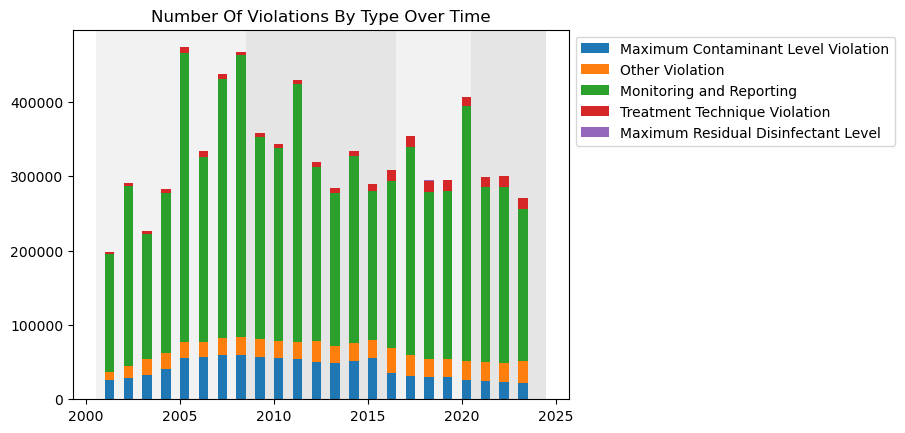

In [48]:
# plot the data
# arrange the list of violation types from most to least common for the plot
viol_types = ['Monitoring and Reporting', 
              'Maximum Contaminant Level Violation', 
              'Other Violation', 
              'Treatment Technique Violation', 
              'Maximum Residual Disinfectant Level']

years = np.array(range(2001,2024))

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(len(years))

for viol_type, viol_count in viol_counts.items():
    p = ax.bar(years, viol_count, width, label=viol_type, bottom=bottom, align='edge', zorder=1)
    bottom += viol_count

ax.set_title("Number Of Violations By Type Over Time")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

#plt.savefig('num_viols_type.png', bbox_inches='tight')
plt.show()

In [49]:
# can all categories be health-based?
can_they = pws_viols.groupby(['Year', 'VIOLATION_CATEGORY_CODE', 'IS_HEALTH_BASED_IND'], as_index=False)[['VIOLATION_ID']].count()
can_they[can_they['IS_HEALTH_BASED_IND'] == 'Y']['VIOLATION_CATEGORY_CODE'].unique()

array(['Maximum Contaminant Level Violation',
       'Treatment Technique Violation',
       'Maximum Residual Disinfectant Level'], dtype=object)

In [50]:
# answer is no, health-based violations are MCL, treatment, or residual violations

## Percentage of violations that were health-based by year

Text(46.972222222222214, 0.5, 'Percent Violations Health-Based')

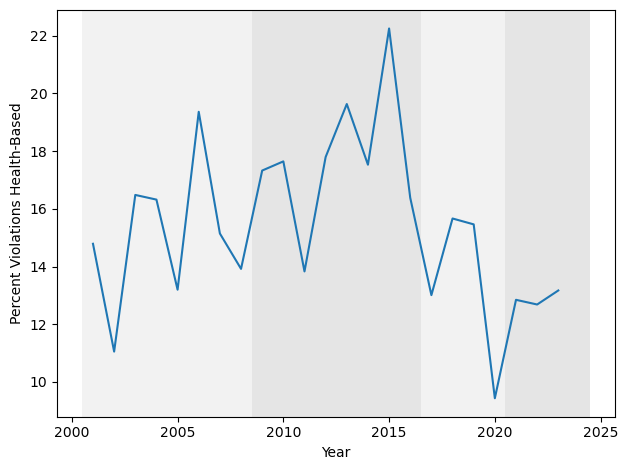

In [51]:
per_health_based = pd.DataFrame((pws_viols.groupby(['Year', 'IS_HEALTH_BASED_IND'])[['VIOLATION_ID']].count()['VIOLATION_ID'][:,'Y'] / (pws_viols.groupby(['Year', 'IS_HEALTH_BASED_IND'])[['VIOLATION_ID']].count()['VIOLATION_ID'][:,'Y']+pws_viols.groupby(['Year', 'IS_HEALTH_BASED_IND'])[['VIOLATION_ID']].count()['VIOLATION_ID'][:,'N'])) * 100)
sns.lineplot(data=per_health_based, x='Year', y='VIOLATION_ID')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.ylabel('Percent Violations Health-Based')
#plt.savefig('per_viols_health_by_year.png')


## Number of health-based violations by category by year

In [52]:
health_cat = pws_viols_health.groupby(['Year', 'VIOLATION_CATEGORY_CODE'], as_index=False).count()
health_cat['VIOLATION_CATEGORY_CODE'].unique()

array(['Maximum Contaminant Level Violation',
       'Treatment Technique Violation',
       'Maximum Residual Disinfectant Level'], dtype=object)

Text(0, 0.5, 'Number of Violations')

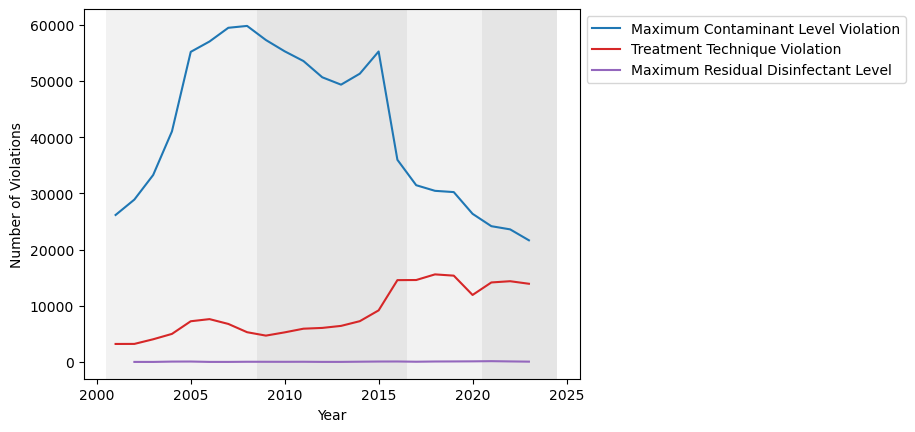

In [53]:
# make a plot of violation categories by year
sns.lineplot(data=health_cat, x='Year', y='VIOLATION_ID', hue='VIOLATION_CATEGORY_CODE', palette=['tab:blue','tab:red','tab:purple'])

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Number of Violations')
#plt.savefig('num_health_viols_by_cat.png', bbox_inches='tight')

## Number of health-based violations  by year

Text(20.347222222222214, 0.5, 'Number of Health-Based Violations')

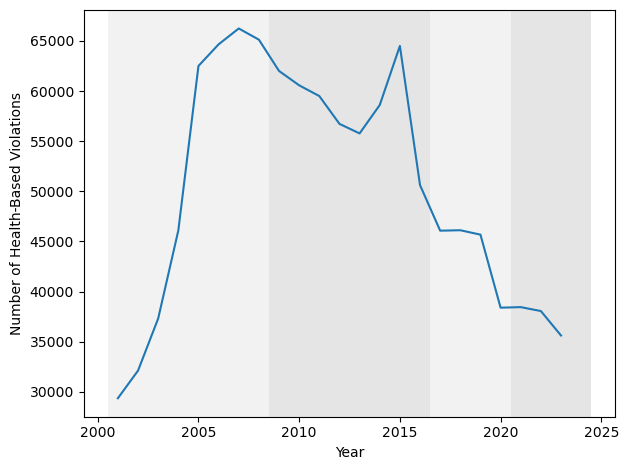

In [54]:
# make a plot of violation categories by year
sns.lineplot(data=pws_viols_health.groupby(['Year']).count(), x='Year', y='VIOLATION_ID')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.ylabel('Number of Health-Based Violations')
#plt.savefig('num_h_viols_by_year.png')

Text(937.4027777777777, 0.5, 'Population Served By PWS With At Least One Health-Based Violation')

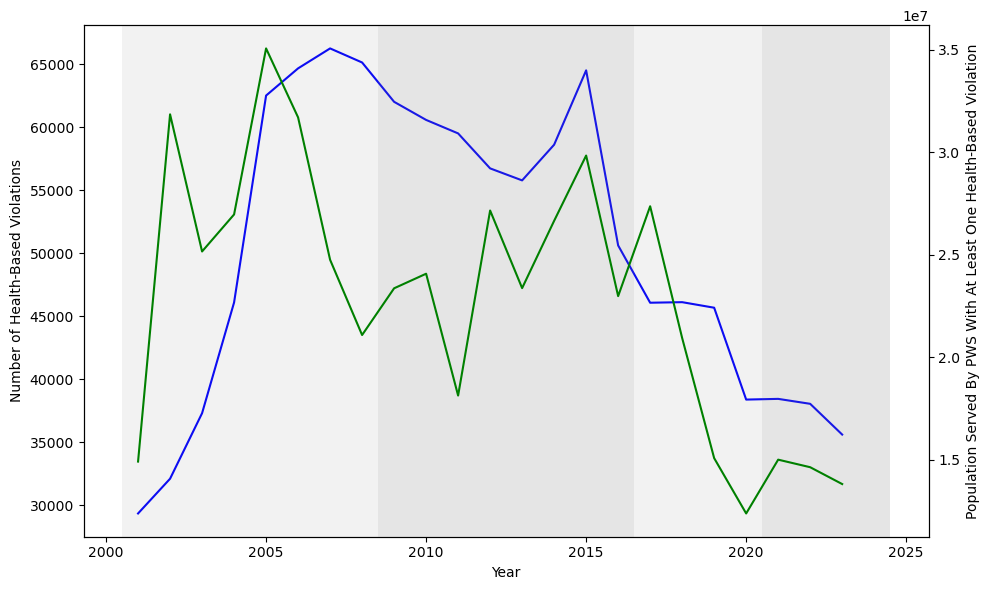

In [55]:
# how many people are affected by health-based violations?
viols_health_pop = pws_viols_health.groupby(['Year','PWSID'], as_index=False).count()[['Year','PWSID']]
viols_health_pop = viols_health_pop.merge(sdwa_pws, on=['PWSID'])[['Year','PWSID','POPULATION_SERVED_COUNT']]
viols_health_pop = viols_health_pop.groupby(['Year'], as_index=False).sum()[['Year','POPULATION_SERVED_COUNT']]

# plot population affected by health-based violations per year 

fig, ax1 = plt.subplots(figsize=(10,6))
sns.lineplot(data=pws_viols_health.groupby(['Year']).count(), x='Year', y='VIOLATION_ID', ax=ax1, color='blue')
ax1.set_ylabel('Number of Health-Based Violations')

ax2 = ax1.twinx()
sns.lineplot(data=viols_health_pop, x='Year', y='POPULATION_SERVED_COUNT', ax=ax2, color='green')
ax2.set_ylabel('Population Served')


# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.ylabel('Population Served By PWS With At Least One Health-Based Violation')
#plt.savefig('pop_served_h_viol.png')

## Number of health-based violations by rule by year

In [56]:
health_rule = pws_viols_health.groupby(['Year', 'RULE_CODE'], as_index=False).count().rename(columns={'VIOLATION_ID':'num_viols_rule'})[['Year','RULE_CODE','num_viols_rule']]
health_rule['RULE_CODE'].unique()

array(['Arsenic Rule', 'Former Total Trihalomethane Rule',
       'Inorganic Chemicals',
       'Interim and Long Term 1 Enhanced Surface Water Treatment Rule',
       'Lead and Copper Rule', 'Nitrate Rule',
       'Radionuclides and Revised Rad Rule',
       'Surface Water Treatment Rule', 'Synthetic Organic Chemicals',
       'Total Coliform Rule', 'Volatile Organic Chemicals',
       'Stage 1 Disinfectants and Disinfection Byproducts Rule',
       'Long Term 2 Enhanced Surface Water Treatment Rule',
       'Ground Water Rule',
       'Stage 2 Disinfectants and Disinfection Byproducts Rule',
       'Revised Total Coliform Rule'], dtype=object)

In [57]:
health_rule

,Year,RULE_CODE,num_viols_rule
0,2001,Arsenic Rule,69
1,2001,Former Total Trihalomethane Rule,255
2,2001,Inorganic Chemicals,318
3,2001,Interim and Long Term 1 Enhanced Surface Water...,2
4,2001,Lead and Copper Rule,481
...,...,...,...
295,2023,Stage 1 Disinfectants and Disinfection Byprodu...,1136
296,2023,Stage 2 Disinfectants and Disinfection Byprodu...,10177
297,2023,Surface Water Treatment Rule,929
298,2023,Synthetic Organic Chemicals,82


In [58]:
# look at top 5 by year
# define a function to return top 5 violation counts
def year_top(df, n=5, column='num_viols_rule'):
  return df.sort_values(column, ascending=False)[:n]
# group by year and apply this function
health_rule_top = health_rule.groupby('Year').apply(year_top, include_groups=False)[['RULE_CODE','num_viols_rule']]

In [59]:
#health_rule_top.iloc[100:120]
health_rule_top

RULE_CODE  num_viols_rule
Year                                                                       
2001 9                                  Total Coliform Rule           22264
     7                         Surface Water Treatment Rule            2718
     5                                         Nitrate Rule            1784
     6                   Radionuclides and Revised Rad Rule            1333
     4                                 Lead and Copper Rule             481
...                                                     ...             ...
2023 296  Stage 2 Disinfectants and Disinfection Byprodu...           10177
     294                        Revised Total Coliform Rule            7190
     287                                  Ground Water Rule            3847
     292                                       Nitrate Rule            3003
     293                 Radionuclides and Revised Rad Rule            2678

[115 rows x 2 columns]

In [60]:
health_rule_top['RULE_CODE'].value_counts()

RULE_CODE
Radionuclides and Revised Rad Rule                               23
Nitrate Rule                                                     17
Total Coliform Rule                                              15
Arsenic Rule                                                     15
Stage 1 Disinfectants and Disinfection Byproducts Rule           12
Stage 2 Disinfectants and Disinfection Byproducts Rule           10
Ground Water Rule                                                 9
Revised Total Coliform Rule                                       8
Surface Water Treatment Rule                                      4
Interim and Long Term 1 Enhanced Surface Water Treatment Rule     1
Lead and Copper Rule                                              1
Name: count, dtype: int64

Text(50.722222222222186, 0.5, 'Rule Code')

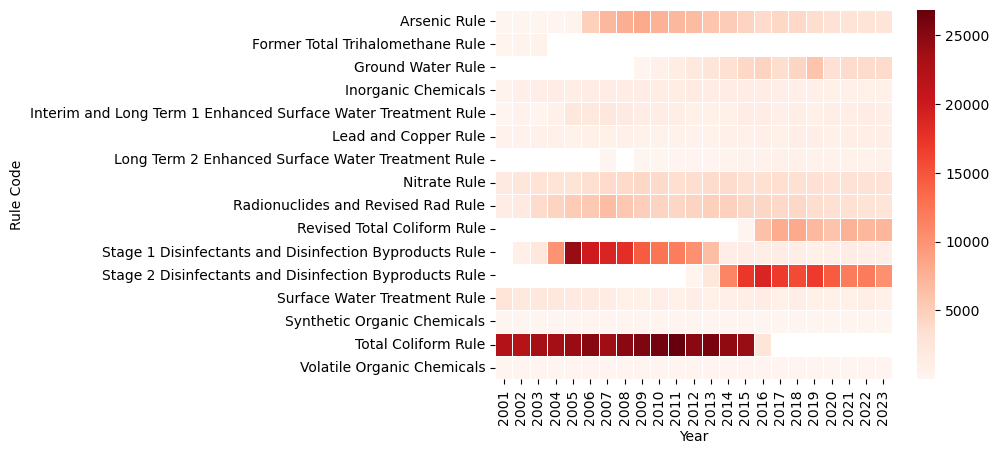

In [61]:
# grid plot of health-based violations
health_rule_reformat = (health_rule.pivot(index='RULE_CODE', columns='Year', values='num_viols_rule'))
sns.heatmap(health_rule_reformat, linewidth=.5, cmap='Reds')
plt.ylabel('Rule Code')
#plt.savefig('num_health_viols_by_rule_heat.png', bbox_inches='tight')

In [62]:
# calculate values as a percentage
for year in range(2001,2024):
    health_rule_reformat[year] = (health_rule_reformat[year] / num_viols_health[year]) * 100

In [63]:
# num_viols[2001]
# health_rule_top.loc[2001]
health_rule_reformat

Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
RULE_CODE,,,,,,,,,,,,,,,,,,,,,
Arsenic Rule,0.235038,0.323856,0.251943,0.340623,0.612771,7.480668,10.556746,12.001351,13.283984,12.397022,...,8.947889,7.133002,7.606140,8.942525,8.845086,7.991068,7.989060,7.493627,7.599727,7.196608
Former Total Trihalomethane Rule,0.868617,1.195777,1.452694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ground Water Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.219330,1.373595,...,5.559158,6.346992,8.886343,7.837732,9.367681,12.888607,8.408440,9.686313,9.922741,10.801932
Inorganic Chemicals,1.083217,3.110890,2.934870,2.735833,2.012703,1.950201,2.163280,2.125111,2.185237,2.524310,...,2.467324,2.238656,2.503112,2.346327,2.146760,2.097382,2.328731,2.086043,2.280969,2.341776
Interim and Long Term 1 Enhanced Surface Water Treatment Rule,0.006813,1.535204,0.774591,1.410223,3.193447,3.054439,3.164156,2.651783,2.270711,2.314639,...,1.581749,2.209200,2.870577,2.075013,2.554428,1.985726,2.797604,3.183686,3.403059,3.417195
Lead and Copper Rule,1.638451,1.591256,1.881533,1.598976,0.849559,1.142901,1.292232,0.971962,0.996662,0.881610,...,1.080094,1.131730,1.898572,1.849279,2.450343,2.351344,2.193279,3.152474,3.308456,3.102712
Long Term 2 Enhanced Surface Water Treatment Rule,NaN,NaN,NaN,NaN,NaN,NaN,0.004529,NaN,0.025804,0.175001,...,0.598915,0.665085,0.942371,1.484633,1.617660,1.267624,1.312842,1.404567,1.479477,1.836356
Nitrate Rule,6.076915,7.644879,7.938890,6.148572,4.554981,5.216517,5.738051,6.022172,6.650862,6.473395,...,6.350886,5.161000,6.523500,7.729206,7.223090,6.990542,7.892680,8.094470,8.254060,8.432077
Radionuclides and Revised Rad Rule,4.540655,5.807617,9.906191,9.598195,8.457194,8.518404,9.872890,8.604858,8.021675,7.468921,...,8.232945,6.512875,8.463560,8.660358,8.892792,7.896926,8.614222,8.484628,7.704840,7.519515


In [64]:
health_rule_reformat.index

Index(['Arsenic Rule', 'Former Total Trihalomethane Rule', 'Ground Water Rule',
       'Inorganic Chemicals',
       'Interim and Long Term 1 Enhanced Surface Water Treatment Rule',
       'Lead and Copper Rule',
       'Long Term 2 Enhanced Surface Water Treatment Rule', 'Nitrate Rule',
       'Radionuclides and Revised Rad Rule', 'Revised Total Coliform Rule',
       'Stage 1 Disinfectants and Disinfection Byproducts Rule',
       'Stage 2 Disinfectants and Disinfection Byproducts Rule',
       'Surface Water Treatment Rule', 'Synthetic Organic Chemicals',
       'Total Coliform Rule', 'Volatile Organic Chemicals'],
      dtype='object', name='RULE_CODE')

In [65]:
health_rule_top['RULE_CODE'].unique()

array(['Total Coliform Rule', 'Surface Water Treatment Rule',
       'Nitrate Rule', 'Radionuclides and Revised Rad Rule',
       'Lead and Copper Rule',
       'Stage 1 Disinfectants and Disinfection Byproducts Rule',
       'Interim and Long Term 1 Enhanced Surface Water Treatment Rule',
       'Arsenic Rule',
       'Stage 2 Disinfectants and Disinfection Byproducts Rule',
       'Ground Water Rule', 'Revised Total Coliform Rule'], dtype=object)

In [66]:
# look at percentages for only those rules in top 5 (ever)
health_rule_reformat.loc[health_rule_top['RULE_CODE'].unique()]

Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
RULE_CODE,,,,,,,,,,,,,,,,,,,,,
Total Coliform Rule,75.838812,68.856849,62.495310,51.141196,38.590148,38.725642,35.904713,38.182907,41.150193,43.104786,...,42.000819,37.547091,5.043760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Surface Water Treatment Rule,9.258439,5.963317,5.666041,4.714484,2.743868,2.789978,2.217626,1.429537,1.419195,1.736805,...,1.748968,1.882083,2.558429,2.016409,2.298551,1.992294,2.386038,2.312334,3.121879,2.608525
Nitrate Rule,6.076915,7.644879,7.938890,6.148572,4.554981,5.216517,5.738051,6.022172,6.650862,6.473395,...,6.350886,5.161000,6.523500,7.729206,7.223090,6.990542,7.892680,8.094470,8.254060,8.432077
Radionuclides and Revised Rad Rule,4.540655,5.807617,9.906191,9.598195,8.457194,8.518404,9.872890,8.604858,8.021675,7.468921,...,8.232945,6.512875,8.463560,8.660358,8.892792,7.896926,8.614222,8.484628,7.704840,7.519515
Lead and Copper Rule,1.638451,1.591256,1.881533,1.598976,0.849559,1.142901,1.292232,0.971962,0.996662,0.881610,...,1.080094,1.131730,1.898572,1.849279,2.450343,2.351344,2.193279,3.152474,3.308456,3.102712
Stage 1 Disinfectants and Disinfection Byproducts Rule,NaN,3.110890,6.033235,21.828083,38.556549,30.708320,28.658555,27.572705,23.318335,20.764062,...,1.965669,2.229354,2.483355,2.938878,2.476364,2.066731,2.485022,3.324143,2.790771,3.189757
Interim and Long Term 1 Enhanced Surface Water Treatment Rule,0.006813,1.535204,0.774591,1.410223,3.193447,3.054439,3.164156,2.651783,2.270711,2.314639,...,1.581749,2.209200,2.870577,2.075013,2.554428,1.985726,2.797604,3.183686,3.403059,3.417195
Arsenic Rule,0.235038,0.323856,0.251943,0.340623,0.612771,7.480668,10.556746,12.001351,13.283984,12.397022,...,8.947889,7.133002,7.606140,8.942525,8.845086,7.991068,7.989060,7.493627,7.599727,7.196608
Stage 2 Disinfectants and Disinfection Byproducts Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.144797,26.572407,37.438015,36.477687,34.055425,36.853052,37.603543,31.064350,31.234561,28.575841


In [67]:
#health_rule_reformat.idxmax()
health_rule_reformat[health_rule_reformat==health_rule_reformat.max()]

Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
RULE_CODE,,,,,,,,,,,,,,,,,,,,,
Arsenic Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Former Total Trihalomethane Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ground Water Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inorganic Chemicals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Interim and Long Term 1 Enhanced Surface Water Treatment Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lead and Copper Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Long Term 2 Enhanced Surface Water Treatment Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nitrate Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Radionuclides and Revised Rad Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# export results
#health_rule_reformat.to_csv('health_rule_top.csv')

In [69]:
# do the percentages add up to 100?
health_rule_reformat.sum()

Year
2001    100.0
2002    100.0
2003    100.0
2004    100.0
2005    100.0
2006    100.0
2007    100.0
2008    100.0
2009    100.0
2010    100.0
2011    100.0
2012    100.0
2013    100.0
2014    100.0
2015    100.0
2016    100.0
2017    100.0
2018    100.0
2019    100.0
2020    100.0
2021    100.0
2022    100.0
2023    100.0
dtype: float64

Text(50.722222222222186, 0.5, 'Percentage of Violations by Rule Code')

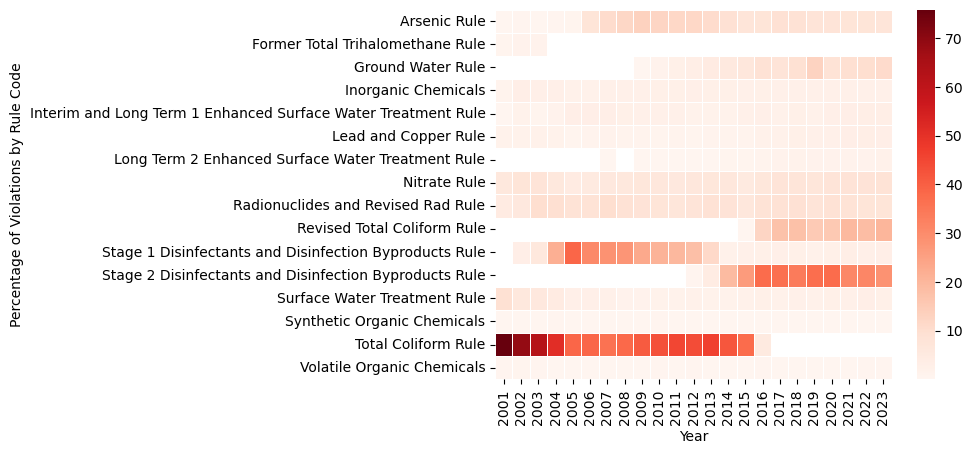

In [70]:
# grid plot (all rules)
sns.heatmap(health_rule_reformat, linewidth=.5, cmap='Reds')
plt.ylabel('Percentage of Violations by Rule Code')
#plt.savefig('per_health_viols_by_rule.png', bbox_inches='tight')

In [71]:
# reorder index so rules with phases/stages are grouped side by side
health_rule_reformat = health_rule_reformat.reindex(['Arsenic Rule', 
                                                     'Former Total Trihalomethane Rule', 
                                                     'Stage 1 Disinfectants and Disinfection Byproducts Rule',
                                                     'Stage 2 Disinfectants and Disinfection Byproducts Rule',
                                                     'Ground Water Rule',
                                                     'Inorganic Chemicals',
                                                     'Lead and Copper Rule',
                                                     'Nitrate Rule',
                                                     'Radionuclides and Revised Rad Rule', 
                                                     'Surface Water Treatment Rule',
                                                     'Interim and Long Term 1 Enhanced Surface Water Treatment Rule',
                                                     'Long Term 2 Enhanced Surface Water Treatment Rule',  
                                                     'Synthetic Organic Chemicals',
                                                     'Total Coliform Rule', 
                                                     'Revised Total Coliform Rule', 
                                                     'Volatile Organic Chemicals'])

Text(50.722222222222186, 0.5, 'Percentage of Violations by Rule Code')

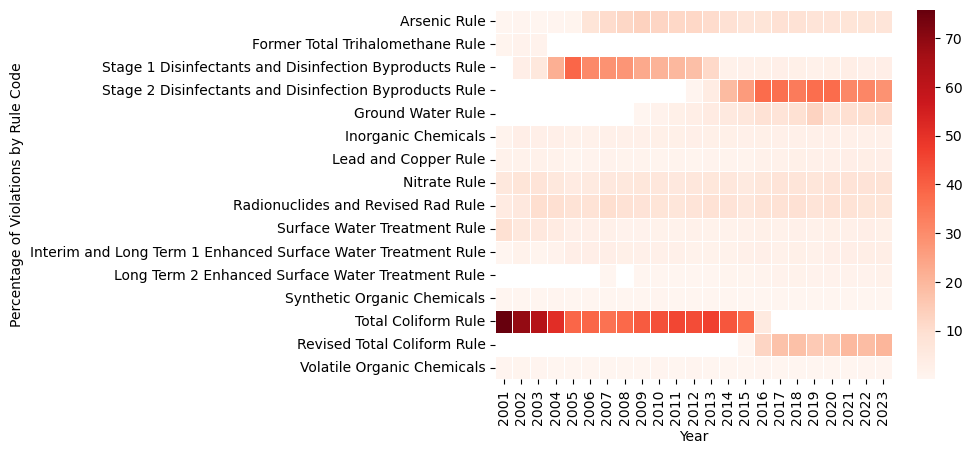

In [72]:
# grid plot (all rules)
sns.heatmap(health_rule_reformat, linewidth=.5, cmap='Reds')
plt.ylabel('Percentage of Violations by Rule Code')
#plt.savefig('per_health_viols_by_rule_ordered.png', bbox_inches='tight')

# Enforcement Analysis

## Enforcement action types

In [73]:
# number of enforcement actions by type for all violation types
viols_enf_type = pws_viols.groupby(['Year', 'ENFORCEMENT_ACTION_TYPE_CODE'], as_index=False).count()[['Year', 'ENFORCEMENT_ACTION_TYPE_CODE','VIOLATION_ID',]].rename(columns={'VIOLATION_ID':'num_enfs_type'})
viols_enf_type

,Year,ENFORCEMENT_ACTION_TYPE_CODE,num_enfs_type
0,2001,Federal Bilateral Compliance Agreement signed,13
1,2001,Federal Civil Case filed,14
2,2001,Federal Complaint for Penalty Consent Order or...,6
3,2001,Federal Complaint for Penalty issued,79
4,2001,Federal Compliance achieved,2777
...,...,...,...
1013,2023,State Unresolved,10
1014,2023,State Variance/Exemption issued,15
1015,2023,State Violation/Reminder Notice,55946
1016,2023,State no additional Formal Action needed,578


Text(50.722222222222186, 0.5, 'Enforcement Action Type')

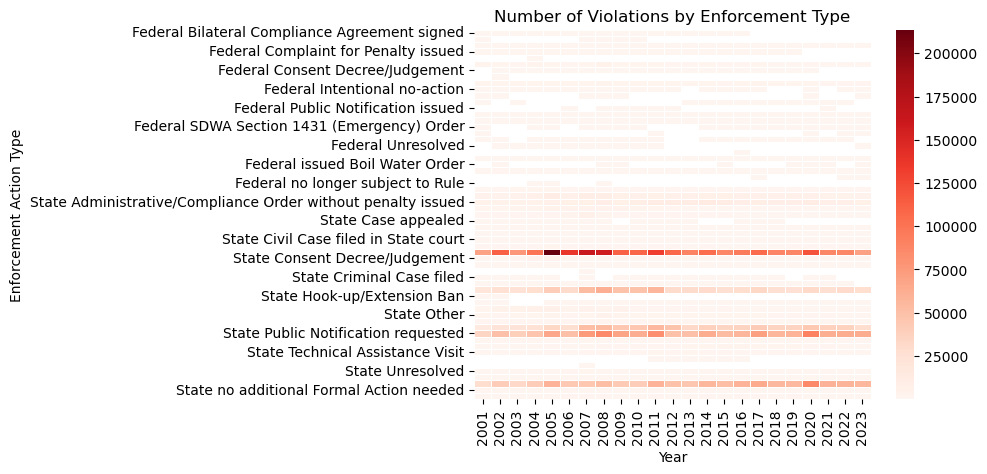

In [74]:
# plot using a heatmap
viols_enf_type_reformat = (viols_enf_type.pivot(index='ENFORCEMENT_ACTION_TYPE_CODE', columns='Year', values='num_enfs_type'))
sns.heatmap(viols_enf_type_reformat, linewidth=.5, cmap='Reds')
plt.title('Number of Violations by Enforcement Type')
plt.ylabel('Enforcement Action Type')

In [75]:
# most of the enforcement actions are only a few types
# narrow down to most common over the years

In [76]:
# filter the dataset for the top 10 action types from 2001-2023

# group the original viols df by enforcement type over all years
viols_enf_type_top10 = pws_viols.groupby(['ENFORCEMENT_ACTION_TYPE_CODE'], as_index=False).count()[['ENFORCEMENT_ACTION_TYPE_CODE','VIOLATION_ID']]

# list of the top 10 types
viols_enf_type_top10_vals = list(viols_enf_type_top10.sort_values(by='VIOLATION_ID',ascending=False).head(10)['ENFORCEMENT_ACTION_TYPE_CODE'])

# create a new viols df by filtering for only the top 10 enforcement types
viols_enf_type_top10 = pws_viols[pws_viols['ENFORCEMENT_ACTION_TYPE_CODE'].isin(viols_enf_type_top10_vals)]

# group this new df by year 
viols_enf_type_top10 = viols_enf_type_top10.groupby(['Year', 'ENFORCEMENT_ACTION_TYPE_CODE'], as_index=False).count()[['Year', 'ENFORCEMENT_ACTION_TYPE_CODE','ENFORCEMENT_ID',]].rename(columns={'ENFORCEMENT_ID':'num_enfs'})
viols_enf_type_top10

,Year,ENFORCEMENT_ACTION_TYPE_CODE,num_enfs
0,2001,Federal Final Administrative Order issued,2196
1,2001,State Administrative/Compliance Order with pen...,3688
2,2001,State Administrative/Compliance Order without ...,4433
3,2001,State Compliance achieved,69834
4,2001,State Formal Notice of Violation issued,19515
...,...,...,...
225,2023,State Intentional no-action,200
226,2023,State Other,636
227,2023,State Public Notification received,28481
228,2023,State Public Notification requested,63006


Text(50.722222222222186, 0.5, 'Top 10 Enforcement Action Types')

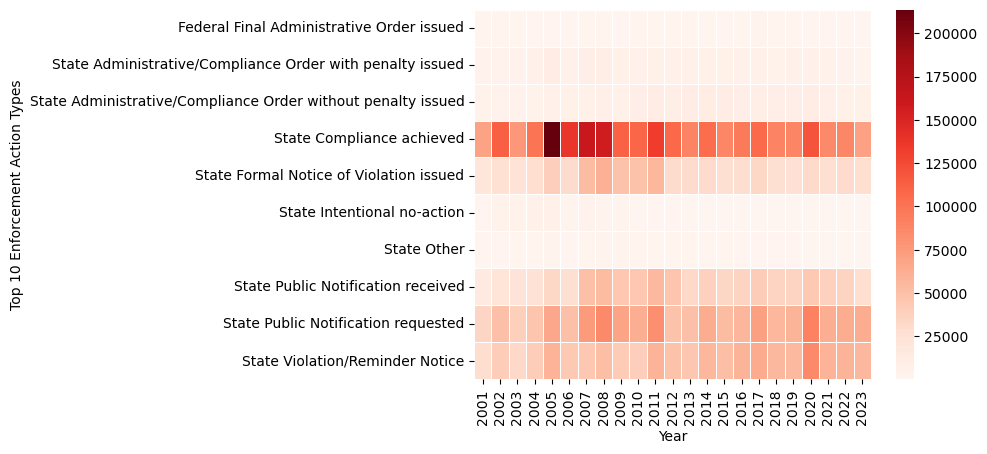

In [77]:
# plot heatmap
viols_enf_type_top10_reformat = (viols_enf_type_top10.pivot(index='ENFORCEMENT_ACTION_TYPE_CODE', columns='Year', values='num_enfs'))
sns.heatmap(viols_enf_type_top10_reformat, linewidth=.5, cmap='Reds')
plt.ylabel('Top 10 Enforcement Action Types')

# most enforcements are resolved by states

## Enforcement frequency as a percentage

In [78]:
# create a dictionary of {year : total number of violations} 
num_viols_any_type = pws_viols.groupby(['Year']).count().rename(columns={'VIOLATION_ID':'num_viols_tot_yr'})['num_viols_tot_yr'].to_dict() 

# add a column for the total violations per year values
viols_enf_type_top10['yr_viols_tot'] = viols_enf_type_top10['Year']
viols_enf_type_top10['yr_viols_tot'] = viols_enf_type_top10['yr_viols_tot'].map(num_viols_any_type)

# calculate the percentages
viols_enf_type_top10['per_enfs'] = (viols_enf_type_top10['num_enfs']/viols_enf_type_top10['yr_viols_tot']) * 100
viols_enf_type_top10

,Year,ENFORCEMENT_ACTION_TYPE_CODE,num_enfs,yr_viols_tot,per_enfs
0,2001,Federal Final Administrative Order issued,2196,198497,1.106314
1,2001,State Administrative/Compliance Order with pen...,3688,198497,1.857963
2,2001,State Administrative/Compliance Order without ...,4433,198497,2.233283
3,2001,State Compliance achieved,69834,198497,35.181388
4,2001,State Formal Notice of Violation issued,19515,198497,9.831383
...,...,...,...,...,...
225,2023,State Intentional no-action,200,270405,0.073963
226,2023,State Other,636,270405,0.235203
227,2023,State Public Notification received,28481,270405,10.532719
228,2023,State Public Notification requested,63006,270405,23.300605


In [79]:
# check the total percentages - won't be 100% because we are only looking at top 10
viols_enf_type_top10.groupby('Year').sum()['per_enfs']

Year
2001    91.610956
2002    92.678024
2003    92.844489
2004    91.848405
2005    93.166486
2006    92.436794
2007    93.383209
2008    93.233634
2009    94.729194
2010    95.183492
2011    95.128125
2012    95.256396
2013    94.666920
2014    94.740447
2015    95.484089
2016    96.332870
2017    95.131724
2018    96.121548
2019    95.547115
2020    96.350392
2021    96.610062
2022    96.607158
2023    95.514136
Name: per_enfs, dtype: float64

In [80]:
# the top 10 enforcement types are responsible for an increasing proportion of violations over the years

Text(0.5, 1.0, 'Top 10 Enforcement Action Types as a Percentage of Violations')

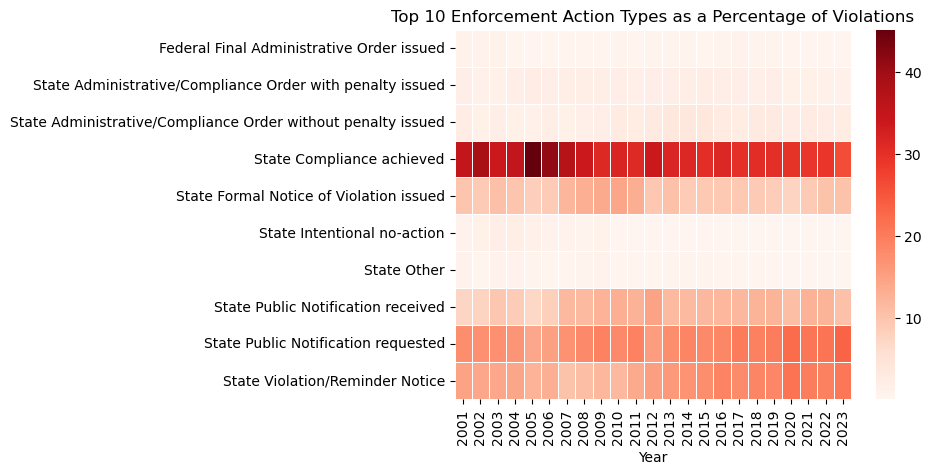

In [81]:
# plot heatmap
viols_enf_type_top10_reformat = (viols_enf_type_top10.pivot(index='ENFORCEMENT_ACTION_TYPE_CODE', columns='Year', values='per_enfs'))
sns.heatmap(viols_enf_type_top10_reformat, linewidth=.5, cmap='Reds')
plt.ylabel('')
plt.title('Top 10 Enforcement Action Types as a Percentage of Violations')
#plt.savefig('per_enf_by_type_top10_heat_corrected.png', bbox_inches='tight')

In [82]:
# "State Compliance achieved" is consistently the most common enforcement type but is never half or more of violations
viols_enf_type_top10[viols_enf_type_top10['ENFORCEMENT_ACTION_TYPE_CODE']=='State Compliance achieved'].groupby('Year').max()['per_enfs']

Year
2001    35.181388
2002    39.061091
2003    33.682634
2004    35.335380
2005    45.116098
2006    41.104682
2007    36.939617
2008    33.708079
2009    31.066765
2010    31.831252
2011    30.998782
2012    33.787197
2013    31.594010
2014    31.289896
2015    30.295932
2016    31.293917
2017    29.970352
2018    30.464042
2019    29.991808
2020    29.549292
2021    29.037184
2022    28.985981
2023    26.221039
Name: per_enfs, dtype: float64

Text(0, 0.5, 'Percentage of Total')

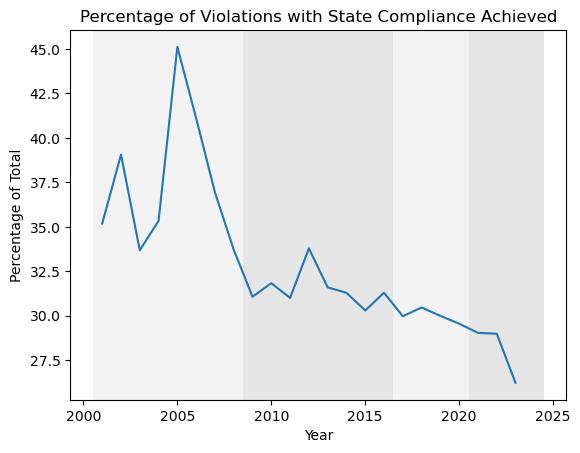

In [83]:
# plot percentage of violations with state compliance achieved by year
sns.lineplot(data=viols_enf_type_top10[viols_enf_type_top10['ENFORCEMENT_ACTION_TYPE_CODE']=='State Compliance achieved'].groupby('Year').max(), x='Year', y='per_enfs')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

#plt.tight_layout()
plt.title('Percentage of Violations with State Compliance Achieved')
plt.ylabel('Percentage of Total')
#plt.savefig('per_st_comp_ach_by_year.png')


## Enforcement action categories: Have systems come back into compliance?

In [85]:
# some values are null 
pws_viols[pws_viols['ENF_ACTION_CATEGORY'].isna() == True]['ENF_ACTION_CATEGORY']

4447409    NaN
4447410    NaN
4447411    NaN
4447412    NaN
4447413    NaN
          ... 
7609250    NaN
7609251    NaN
7609252    NaN
7609253    NaN
7609254    NaN
Name: ENF_ACTION_CATEGORY, Length: 87438, dtype: object

In [86]:
# add a 'None' category
pws_viols['ENF_ACTION_CATEGORY'] = pws_viols['ENF_ACTION_CATEGORY'].fillna(value='None')

# summarize violations by year and enforcement category
viols_enf_cat = pws_viols.groupby(['Year', 'ENF_ACTION_CATEGORY'], as_index=False).count()[['Year', 'ENF_ACTION_CATEGORY','VIOLATION_ID',]].rename(columns={'VIOLATION_ID':'num_enfs_cat'})
viols_enf_cat


,Year,ENF_ACTION_CATEGORY,num_enfs_cat
0,2001,Formal,13378
1,2001,Informal,108226
2,2001,None,3612
3,2001,Resolving,73281
4,2002,Formal,14338
...,...,...,...
87,2022,Resolving,88135
88,2023,Formal,12755
89,2023,Informal,179794
90,2023,None,6102


In [87]:
# add a column for the total violations per year values
viols_enf_cat['yr_viols_tot'] = viols_enf_cat['Year']
viols_enf_cat['yr_viols_tot'] = viols_enf_cat['yr_viols_tot'].map(num_viols_any_type)

# calculate the percentages
viols_enf_cat['per_enfs'] = (viols_enf_cat['num_enfs_cat']/viols_enf_cat['yr_viols_tot']) * 100
viols_enf_cat

,Year,ENF_ACTION_CATEGORY,num_enfs_cat,yr_viols_tot,per_enfs
0,2001,Formal,13378,198497,6.739648
1,2001,Informal,108226,198497,54.522738
2,2001,None,3612,198497,1.819675
3,2001,Resolving,73281,198497,36.917938
4,2002,Formal,14338,290550,4.934779
...,...,...,...,...,...
87,2022,Resolving,88135,300014,29.376962
88,2023,Formal,12755,270405,4.716999
89,2023,Informal,179794,270405,66.490634
90,2023,None,6102,270405,2.256615


In [88]:
# check the math
viols_enf_cat.groupby('Year').sum()['per_enfs']

Year
2001    100.0
2002    100.0
2003    100.0
2004    100.0
2005    100.0
2006    100.0
2007    100.0
2008    100.0
2009    100.0
2010    100.0
2011    100.0
2012    100.0
2013    100.0
2014    100.0
2015    100.0
2016    100.0
2017    100.0
2018    100.0
2019    100.0
2020    100.0
2021    100.0
2022    100.0
2023    100.0
Name: per_enfs, dtype: float64

In [89]:
# create a dictionary to plot the values as stacked bar chart
enf_cats = ['Resolving', 'Informal', 'Formal', 'None']
enf_pers = dict()
for enf_cat in enf_cats:
    array = np.array(viols_enf_cat[viols_enf_cat['ENF_ACTION_CATEGORY'] == enf_cat]['per_enfs'])
    enf_pers.update({enf_cat:array})
enf_pers

{'Resolving': array([36.91793831, 40.34142144, 35.86591093, 37.74852963, 46.40345265,
        42.32059322, 38.36271055, 35.3818237 , 32.59454671, 32.72737337,
        31.81467397, 34.54234576, 32.50116166, 32.36854858, 30.87137416,
        31.95257654, 30.9707751 , 30.93793525, 30.60588211, 29.93514265,
        29.38703771, 29.37696241, 26.53575193]),
 'Informal': array([54.52273838, 51.97212184, 55.98457304, 53.41824504, 45.38171944,
        49.18180566, 54.86547603, 57.29097426, 60.79801251, 60.40051623,
        61.74698515, 58.31213039, 59.83504414, 59.69411258, 61.24941352,
        61.52070973, 62.19596216, 62.51995788, 62.16097277, 63.80252302,
        64.53145675, 64.60265188, 66.49063442]),
 'Formal': array([6.73964846, 4.93477887, 7.01104892, 7.16473508, 6.29741537,
        6.42546106, 5.68437226, 5.90758603, 6.10609799, 6.58923197,
        5.8216567 , 6.57735808, 7.14421493, 7.12969555, 7.52042337,
        5.99201841, 5.82295637, 6.0216734 , 6.19998375, 4.78405871,
        5.0

In [90]:
# What's the range? 
print("Max % of enforcements resolving:",enf_pers['Resolving'].max())
print("Min % of enforcements resolving:",enf_pers['Resolving'].min())

Max % of enforcements resolving: 46.40345265167111
Min % of enforcements resolving: 26.53575192766406


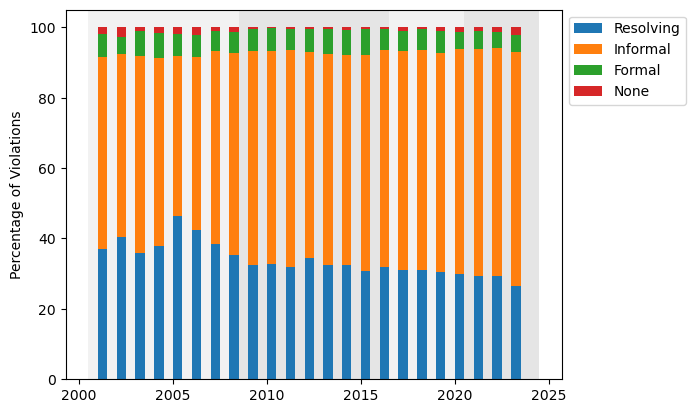

In [91]:
# plot the data
years = np.array(range(2001,2024))

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(len(years))

for enf_cat, enf_per in enf_pers.items():
    p = ax.bar(years, enf_per, width, label=enf_cat, bottom=bottom, align='edge', zorder=1)
    bottom += enf_per

#ax.set_title("Violation Enforcement Categories Over Time")
plt.ylabel("Percentage of Violations")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

#plt.savefig('enf_cats_time.png', bbox_inches='tight')
plt.show()

## Enforcement action categories for health-based violations

In [92]:
# add a 'None' category
pws_viols_health['ENF_ACTION_CATEGORY'] = pws_viols_health['ENF_ACTION_CATEGORY'].fillna(value='None')

# look at enforcement category for health-based violations 
viols_health_enf_cat = pws_viols_health.groupby(['Year', 'ENF_ACTION_CATEGORY'], as_index=False).count()[['Year', 'ENF_ACTION_CATEGORY','VIOLATION_ID',]].rename(columns={'VIOLATION_ID':'num_enfs_cat'})

# add a column for the total violations per year values
viols_health_enf_cat['yr_viols_health'] = viols_health_enf_cat['Year']
viols_health_enf_cat['yr_viols_health'] = viols_health_enf_cat['yr_viols_health'].map(num_viols_health)

# calculate the percentages
viols_health_enf_cat['per_enfs'] = (viols_health_enf_cat['num_enfs_cat']/viols_health_enf_cat['yr_viols_health']) * 100
viols_health_enf_cat

# make a dictionary to plot the values as stacked bar chart
enf_cats = ['Resolving', 'Informal', 'Formal', 'None']
enf_pers_health = dict()
for enf_cat in enf_cats:
    array = np.array(viols_health_enf_cat[viols_health_enf_cat['ENF_ACTION_CATEGORY'] == enf_cat]['per_enfs'])
    enf_pers_health.update({enf_cat:array})
enf_pers_health

C:\Users\jenni\AppData\Local\Temp\ipykernel_30104\3470836203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pws_viols_health['ENF_ACTION_CATEGORY'] = pws_viols_health['ENF_ACTION_CATEGORY'].fillna(value='None')


{'Resolving': array([25.28868754, 26.19499891, 25.78933262, 25.04339148, 24.84840728,
        24.68450356, 24.70637964, 24.75048368, 24.83268018, 25.22659358,
        24.37269962, 24.67960583, 24.22770058, 23.72965225, 23.44387083,
        22.53393129, 21.65306477, 20.98620869, 20.16814082, 19.15082053,
        17.88742652, 17.3595417 , 14.61223115]),
 'Informal': array([64.08011718, 64.5782082 , 62.8196194 , 61.01275709, 59.85152713,
        59.68450356, 60.07215966, 59.50311703, 58.72401503, 59.40631655,
        61.73341625, 61.3781797 , 62.36127297, 62.28372522, 62.21881153,
        61.59393089, 62.3762806 , 63.15812299, 63.35931342, 62.99817661,
        65.41902929, 66.51600357, 70.30662099]),
 'Formal': array([ 8.93483667,  7.35527668,  9.46395068, 11.73739478, 13.75293986,
        14.55459326, 14.72781619, 15.30417959, 16.06592804, 15.25647587,
        13.78800356, 13.86112433, 13.31779471, 13.88424393, 14.2225943 ,
        15.77335678, 15.92290328, 15.77326741, 16.40686575, 17.7

In [93]:
# What's the range?
print("Max % of health-based enforcements resolving:",enf_pers_health['Resolving'].max())
print("Min % of health-based enforcements resolving:",enf_pers_health['Resolving'].min())

Max % of health-based enforcements resolving: 26.194998910098715
Min % of health-based enforcements resolving: 14.612231145055315


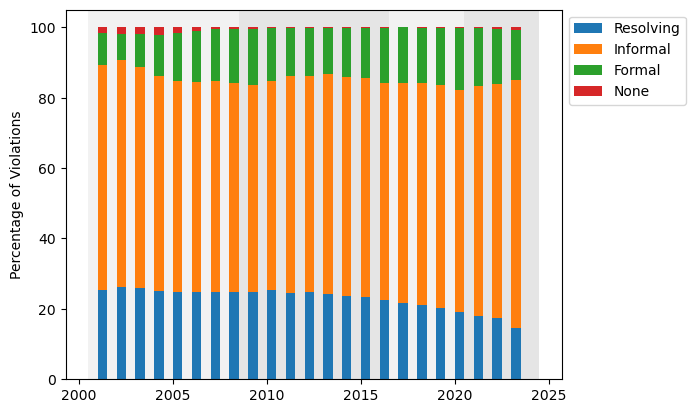

In [94]:
# plot the data
years = np.array(range(2001,2024))

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(len(years))

for enf_cat, enf_per in enf_pers_health.items():
    p = ax.bar(years, enf_per, width, label=enf_cat, bottom=bottom, align='edge', zorder=1)
    bottom += enf_per

#ax.set_title("Violation Enforcement Categories Over Time, Health-Based Violations Only")
plt.ylabel("Percentage of Violations")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

#plt.savefig('enf_cats_health_time.png', bbox_inches='tight')
plt.show()

## Compare enforcement outcomes using 'ENF_ACTION_CATEGORY' and 'VIOLATION_STATUS' - Does the latter give us a different picture? 

In [95]:
# same process but use 'VIOLATION_STATUS' field instead of 'ENF_ACTION_CATEGORY'
viols_viol_stat = pws_viols.groupby(['Year', 'VIOLATION_STATUS'], as_index=False).count()[['Year', 'VIOLATION_STATUS','VIOLATION_ID',]].rename(columns={'VIOLATION_ID':'num_viols_stat'})

# add a column for the total violations per year values
viols_viol_stat['yr_viols_tot'] = viols_viol_stat['Year']
viols_viol_stat['yr_viols_tot'] = viols_viol_stat['yr_viols_tot'].map(num_viols_any_type)

# calculate the percentages
viols_viol_stat['per_viols_stat'] = (viols_viol_stat['num_viols_stat']/viols_viol_stat['yr_viols_tot']) * 100
viols_viol_stat

,Year,VIOLATION_STATUS,num_viols_stat,yr_viols_tot,per_viols_stat
0,2001,Addressed,48,198497,0.024182
1,2001,Archived,19931,198497,10.040958
2,2001,Resolved,178473,198497,89.912190
3,2001,Unaddressed,45,198497,0.022670
4,2002,Addressed,71,290550,0.024436
...,...,...,...,...,...
87,2022,Unaddressed,7520,300014,2.506550
88,2023,Addressed,2357,270405,0.871655
89,2023,Archived,52786,270405,19.521089
90,2023,Resolved,202375,270405,74.841442


In [96]:
# create a dictionary to plot the values as stacked bar chart
viol_stats = ['Resolved', 'Archived', 'Addressed', 'Unaddressed']
stat_pers = dict()
for viol_stat in viol_stats:
    array = np.array(viols_viol_stat[viols_viol_stat['VIOLATION_STATUS'] == viol_stat]['per_viols_stat'])
    stat_pers.update({viol_stat:array})
stat_pers

{'Resolved': array([89.91219011, 91.14541387, 92.65054759, 93.44607682, 94.82376739,
        93.74913898, 94.42080497, 94.50812507, 95.34679004, 95.33032101,
        95.33895547, 94.90784169, 93.91993692, 93.05875455, 92.46819198,
        94.17984794, 92.44387971, 92.3256446 , 90.78922425, 88.25243983,
        87.27060695, 86.21564327, 74.84144154]),
 'Archived': array([10.0409578 ,  8.77336087,  7.25137725,  6.45336053,  5.11858989,
         6.11938689,  5.46052767,  5.39163405,  4.50118629,  4.34018826,
         4.34584523,  4.4948156 ,  5.46227066,  6.35555449,  6.80629537,
         5.07021922,  6.7934491 ,  6.48061963,  7.63293659, 10.37152273,
        10.39603299, 10.6921677 , 19.52108874]),
 'Addressed': array([0.02418173, 0.02443641, 0.04329444, 0.02691113, 0.03146068,
        0.05660276, 0.0802548 , 0.05172344, 0.09277915, 0.1418762 ,
        0.11203987, 0.18604213, 0.27387037, 0.27489785, 0.36189385,
        0.36833128, 0.36199351, 0.53707919, 0.74948207, 0.42001214,
        0

In [97]:
# This looks like a very different picture
# What's the range of resolved violations? 
print("Max % of violations resolved:",stat_pers['Resolved'].max())
print("Min % of violations resolved:",stat_pers['Resolved'].min())

Max % of violations resolved: 95.34679003686016
Min % of violations resolved: 74.84144154139162


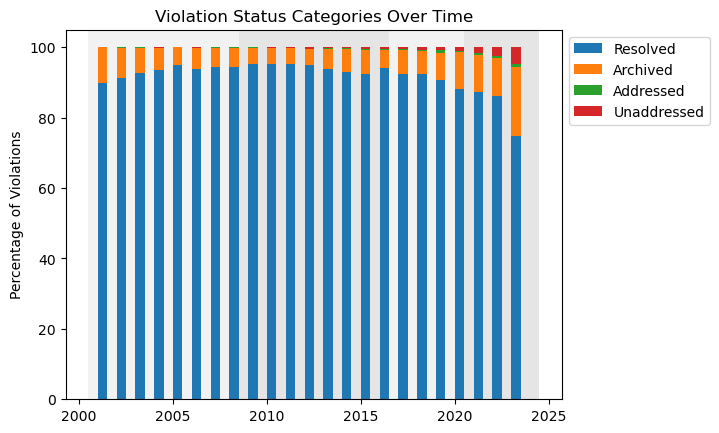

In [98]:
# plot the data
years = np.array(range(2001,2024))

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(len(years))

for viol_stat, stat_per in stat_pers.items():
    p = ax.bar(years, stat_per, width, label=viol_stat, bottom=bottom, align='edge', zorder=1)
    bottom += stat_per

ax.set_title("Violation Status Categories Over Time")
plt.ylabel("Percentage of Violations")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

#plt.savefig('viol_stats_time.png', bbox_inches='tight')
plt.show()

This is a really different picture from the enforcement action categories

We see a drop-off in resolved violations through Trump 1 and Biden

We see an increase in 'Archived': The violation is not Resolved, but is more than five years past its noncompliance period end date. In keeping with the 
Enforcement Response Policy, the violation no longer contributes to the public water system's overall compliance status. Unresolved violations are also marked as Archived when a system ceases operations (becomes inactive).

Can't really see how this makes much sense, but there it is 

We also see an increase in 'Unaddressed': The violation is not Resolved or Archived, and has not been addressed by formal enforcement.

That's a more clear-cut drop-off in enforcement activity

## Violations & Enforcement by State

In [99]:
# aggregate the violations dataset by pws keeping state & year info
# count violations by pws
pws_viols_agg = pws_viols.groupby(['STATE_CODE', 'PWSID', 'Year'], as_index=False)['VIOLATION_ID'].count().rename(columns={'VIOLATION_ID':'num_viols_pws'})

# add resolving violations 
num_viols_res = pws_viols[pws_viols['ENF_ACTION_CATEGORY']=='Resolving'].groupby(['STATE_CODE', 'PWSID', 'Year'], as_index=False)['VIOLATION_ID'].count().rename(columns={'VIOLATION_ID':'num_viols_pws_res'})
pws_viols_agg = pd.merge(pws_viols_agg, num_viols_res, on=['STATE_CODE', 'PWSID', 'Year'])

# add health-related violations
pws_viols_h_pws = pws_viols_health.groupby(['STATE_CODE', 'PWSID', 'Year'], as_index=False)['VIOLATION_ID'].count().rename(columns={'VIOLATION_ID':'num_viols_h_pws'})
pws_viols_agg = pd.merge(pws_viols_agg, pws_viols_h_pws, on=['STATE_CODE', 'PWSID', 'Year'])

# add health-related violations resolving
num_viols_h_res = pws_viols_health[pws_viols_health['ENF_ACTION_CATEGORY']=='Resolving'].groupby(['STATE_CODE', 'PWSID', 'Year'], as_index=False)['VIOLATION_ID'].count().rename(columns={'VIOLATION_ID':'num_viols_h_pws_res'})
pws_viols_agg = pd.merge(pws_viols_agg, num_viols_h_res, on=['STATE_CODE', 'PWSID', 'Year'])
pws_viols_agg

,STATE_CODE,PWSID,Year,num_viols_pws,num_viols_pws_res,num_viols_h_pws,num_viols_h_pws_res
0,AK,100211202,2016,2,2,2,2
1,AK,100211202,2020,2,2,2,2
2,AK,100211202,2022,43,19,30,12
3,AK,AK2110106,2004,9,9,1,1
4,AK,AK2110106,2005,2,2,2,2
...,...,...,...,...,...,...,...
134692,WY,WY5680243,2021,3,3,2,2
134693,WY,WY5680243,2023,5,5,1,1
134694,WY,WY5680244,2003,9,3,9,3
134695,WY,WY5680244,2017,2,2,1,1


In [100]:
# aggregate to state level
# mapping for renaming
col_names = {'num_viols_pws':'num_viols', 
             'num_viols_pws_res':'num_viols_res',
             'num_viols_h_pws':'num_viols_h',
             'num_viols_h_pws_res':'num_viols_h_res'            
            }
pws_viols_state = pws_viols_agg.groupby(['STATE_CODE','Year'], as_index=False).sum().drop(columns=['PWSID']).rename(columns=col_names)
pws_viols_state

,STATE_CODE,Year,num_viols,num_viols_res,num_viols_h,num_viols_h_res
0,AK,2001,151,86,34,14
1,AK,2002,227,129,57,17
2,AK,2003,1128,616,244,127
3,AK,2004,2053,1051,269,148
4,AK,2005,3252,1699,528,332
...,...,...,...,...,...,...
1220,WY,2019,286,174,110,61
1221,WY,2020,285,158,118,64
1222,WY,2021,180,114,93,59
1223,WY,2022,718,379,63,42


In [101]:
# add violation duration info
non_comp_dur = pws_viols.groupby(['STATE_CODE', 'Year'], as_index=False)['non_compl_duration'].mean()
non_comp_dur['avg_non_compl_dur'] = non_comp_dur['non_compl_duration'].dt.days
non_comp_dur = non_comp_dur.drop(columns=['non_compl_duration'])
# join the duration to the aggregated df
pws_viols_state = pd.merge(pws_viols_state, non_comp_dur, on=['STATE_CODE','Year'])
pws_viols_state

,STATE_CODE,Year,num_viols,num_viols_res,num_viols_h,num_viols_h_res,avg_non_compl_dur
0,AK,2001,151,86,34,14,164
1,AK,2002,227,129,57,17,632
2,AK,2003,1128,616,244,127,287
3,AK,2004,2053,1051,269,148,233
4,AK,2005,3252,1699,528,332,326
...,...,...,...,...,...,...,...
1220,WY,2019,286,174,110,61,150
1221,WY,2020,285,158,118,64,758
1222,WY,2021,180,114,93,59,169
1223,WY,2022,718,379,63,42,138


In [102]:
# state averages over the entire time period
pws_viols_state_avgs = pws_viols_state.groupby('STATE_CODE').mean().drop(['Year'], axis=1)
# add a column for percent violations resolved
pws_viols_state_avgs['per_viols_res'] = (pws_viols_state_avgs['num_viols_res'] / pws_viols_state_avgs['num_viols']) * 100
# add a column for percent health based violations resolved
pws_viols_state_avgs['per_viols_h_res'] = (pws_viols_state_avgs['num_viols_h_res'] / pws_viols_state_avgs['num_viols_h']) * 100

In [103]:
# add number of pws per state
num_pws_state = pws_viols_agg.groupby('STATE_CODE').count().rename(columns={'PWSID': 'num_pws'})['num_pws']
# merge with state averages
pws_viols_state_avgs = pd.merge(pws_viols_state_avgs, num_pws_state, on='STATE_CODE')
# calculate number of violations per pws 
pws_viols_state_avgs['num_viols_pws'] = pws_viols_state_avgs['num_viols'] / pws_viols_state_avgs['num_pws']
# calculate number of health-based violations per pws 
pws_viols_state_avgs['num_viols_h_pws'] = pws_viols_state_avgs['num_viols_h'] / pws_viols_state_avgs['num_pws']

In [104]:
pws_viols_state_avgs

,num_viols,num_viols_res,num_viols_h,num_viols_h_res,avg_non_compl_dur,per_viols_res,per_viols_h_res,num_pws,num_viols_pws,num_viols_h_pws
STATE_CODE,,,,,,,,,,
AK,1763.652174,1259.217391,422.304348,264.217391,243.347826,71.398284,62.565634,1901,0.927750,0.222149
AL,210.956522,52.695652,109.565217,27.695652,255.652174,24.979390,25.277778,392,0.538154,0.279503
AR,966.173913,341.217391,695.739130,245.086957,223.304348,35.316353,35.226847,1990,0.485515,0.349618
AS,27.263158,22.894737,10.052632,6.210526,217.684211,83.976834,61.780105,54,0.504873,0.186160
AZ,1589.739130,940.391304,519.826087,248.304348,343.782609,59.153812,47.766812,2746,0.578929,0.189303
CA,2447.695652,1114.913043,1965.652174,876.739130,228.347826,45.549496,44.602964,9546,0.256411,0.205914
CO,2391.565217,669.391304,964.086957,214.478261,302.826087,27.989674,22.246776,2380,1.004859,0.405079
CT,1458.347826,451.695652,684.260870,185.217391,276.956522,30.973108,27.068242,2740,0.532244,0.249730
DC,11.500000,4.333333,7.222222,2.388889,216.222222,37.681159,33.076923,27,0.425926,0.267490


In [105]:
# look at some rankings and map results
# import state boundaries
file = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\boundaries\cb_2018_us_state_500k\cb_2018_us_state_500k.shp" # https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
state_bds = gpd.read_file(file)
state_bds = state_bds.rename(columns={'STUSPS':'STATE_CODE'})
# join violations stats to state boundaries
state_bds = state_bds.merge(pws_viols_state_avgs, on='STATE_CODE')

In [106]:
### top 10 most violations per pws
pws_viols_state_avgs.sort_values('num_viols_pws', ascending=False)['num_viols_pws'].head(10)

STATE_CODE
GU    2.666667
MS    2.003716
WV    1.184420
OK    1.146528
CO    1.004859
TX    0.984222
AK    0.927750
LA    0.917321
PR    0.878554
PA    0.857426
Name: num_viols_pws, dtype: float64

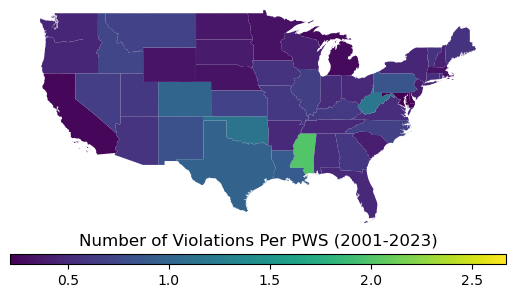

In [107]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='num_viols_pws', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Number of Violations Per PWS (2001-2023)')
#plt.savefig('num_viols_pws_bystate.png')#, bbox_inches='tight')
plt.show()

In [108]:
### top 10 most health violations per pws
pws_viols_state_avgs.sort_values('num_viols_h_pws', ascending=False)['num_viols_h_pws'].head(10)

STATE_CODE
GU    1.619048
OK    0.834859
LA    0.695843
TX    0.640557
KS    0.540597
NM    0.486900
IL    0.478820
MS    0.466075
HI    0.427941
GA    0.412766
Name: num_viols_h_pws, dtype: float64

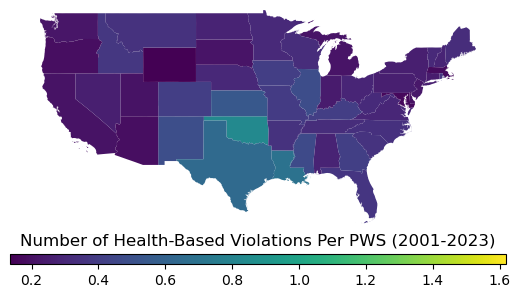

In [109]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='num_viols_h_pws', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Number of Health-Based Violations Per PWS (2001-2023)')
#plt.savefig('num_viols_h_pws_bystate.png', bbox_inches='tight')
plt.show()

In [110]:
### top 10 longest noncompliance duration
pws_viols_state_avgs.sort_values('avg_non_compl_dur', ascending=False)['avg_non_compl_dur'].head(10)

STATE_CODE
HI    392.941176
UT    382.956522
TX    377.521739
ID    377.304348
WA    362.652174
WY    362.391304
AZ    343.782609
NC    331.608696
MP    329.529412
NV    322.521739
Name: avg_non_compl_dur, dtype: float64

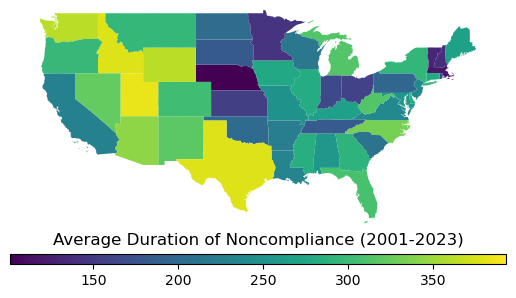

In [111]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='avg_non_compl_dur', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Average Duration of Noncompliance (2001-2023)')
#plt.savefig('avg_dur_bystate.png', bbox_inches='tight')
plt.show()

In [112]:
### top 10 lowest percentage violations resolved
pws_viols_state_avgs.sort_values('per_viols_res', ascending=True)['per_viols_res'].head(10)

STATE_CODE
MN    16.589812
LA    18.801801
RI    19.429014
SC    21.102976
VT    22.559315
WI    22.723820
OK    23.126041
IA    23.332355
HI    23.469388
IL    23.611631
Name: per_viols_res, dtype: float64

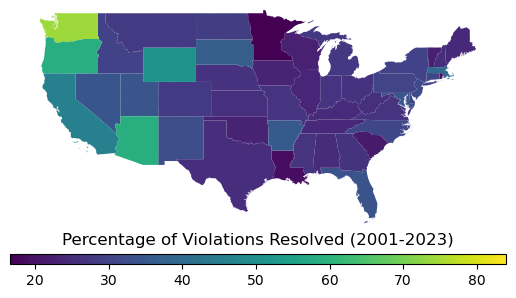

In [113]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='per_viols_res', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Percentage of Violations Resolved (2001-2023)')
#plt.savefig('per_viols_res_bystate.png', bbox_inches='tight')
plt.show()

In [114]:
### top 10 lowest percentage health violations resolved
pws_viols_state_avgs.sort_values('per_viols_h_res', ascending=True)['per_viols_h_res'].head(10)

STATE_CODE
MN    15.853893
LA    17.213988
RI    17.950149
WI    18.452226
HI    19.931271
OK    20.025092
SC    20.414564
IL    20.798868
VT    20.917415
TX    21.403705
Name: per_viols_h_res, dtype: float64

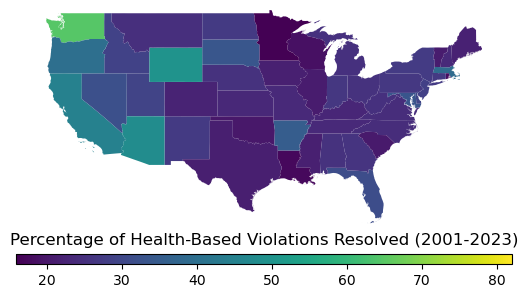

In [115]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='per_viols_h_res', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Percentage of Health-Based Violations Resolved (2001-2023)')
#plt.savefig('per_viols_h_res_bystate.png', bbox_inches='tight')
plt.show()

## State data over time

In [116]:
# merge violations data aggregated to state/year (pws_viols_state) with number of pws per state (num_pws_state)
pws_viols_state_yrs = pd.merge(pws_viols_state, num_pws_state, on='STATE_CODE')

# create a new column for number of viols per pws by year
pws_viols_state_yrs['num_viols_pws'] = pws_viols_state_yrs['num_viols'] / pws_viols_state_yrs['num_pws']

# create a new column for number of health-based viols per pws by year
pws_viols_state_yrs['num_viols_h_pws'] = pws_viols_state_yrs['num_viols_h'] / pws_viols_state_yrs['num_pws']

# create a new column for percentage of violations resolved by year
pws_viols_state_yrs['per_viols_res'] = (pws_viols_state_yrs['num_viols_res'] / pws_viols_state_yrs['num_viols']) * 100

# create a new column for percentage of health-based violations resolved by year
pws_viols_state_yrs['per_viols_h_res'] = (pws_viols_state_yrs['num_viols_h_res'] / pws_viols_state_yrs['num_viols_h']) * 100

In [117]:
pws_viols_state_yrs.head()

,STATE_CODE,Year,num_viols,num_viols_res,num_viols_h,num_viols_h_res,avg_non_compl_dur,num_pws,num_viols_pws,num_viols_h_pws,per_viols_res,per_viols_h_res
0,AK,2001,151,86,34,14,164,1901,0.079432,0.017885,56.953642,41.176471
1,AK,2002,227,129,57,17,632,1901,0.119411,0.029984,56.828194,29.824561
2,AK,2003,1128,616,244,127,287,1901,0.593372,0.128353,54.609929,52.049180
3,AK,2004,2053,1051,269,148,233,1901,1.079958,0.141504,51.193376,55.018587
4,AK,2005,3252,1699,528,332,326,1901,1.710679,0.277749,52.244772,62.878788


<Axes: xlabel='Year', ylabel='STATE_CODE'>

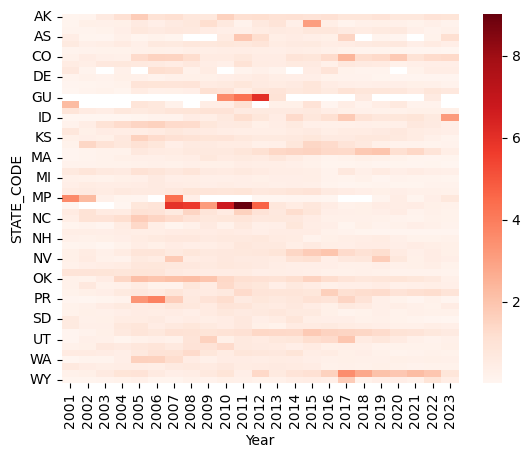

In [118]:
# plot all 50 states over time
# num viols per pws per year
heatmap_data = pws_viols_state_yrs.pivot(index='STATE_CODE', columns='Year', values='num_viols_pws')
sns.heatmap(heatmap_data, cmap='Reds')

In [119]:
# you can see the hot moments for each state but there doesn't seem to be any overarching trend
# note the label font is too large so only some states are labeled

In [120]:
#sns.lineplot(data=pws_viols_state_yrs, x='Year', y='num_viols_pws', hue='STATE_CODE')

<Axes: xlabel='Year', ylabel='STATE_CODE'>

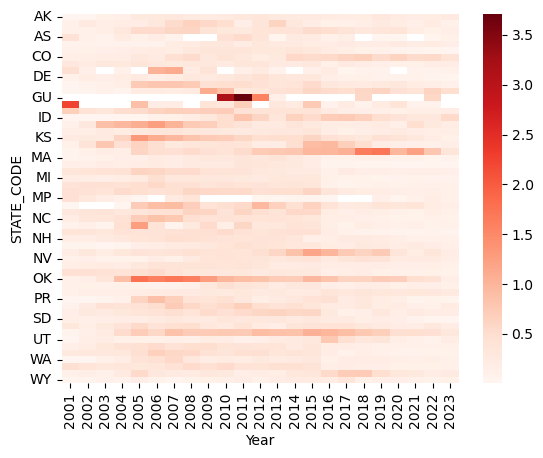

In [121]:
# num health-based viols per pws per year
heatmap_data = pws_viols_state_yrs.pivot(index='STATE_CODE', columns='Year', values='num_viols_h_pws')
sns.heatmap(heatmap_data, cmap='Reds')

In [122]:
# chronic problems become more apparent here
# a few states seem to have had 5-7 year stretches of chronic violations and 1 or 2 states have had longer stretches of chronic problems

<Axes: xlabel='Year', ylabel='STATE_CODE'>

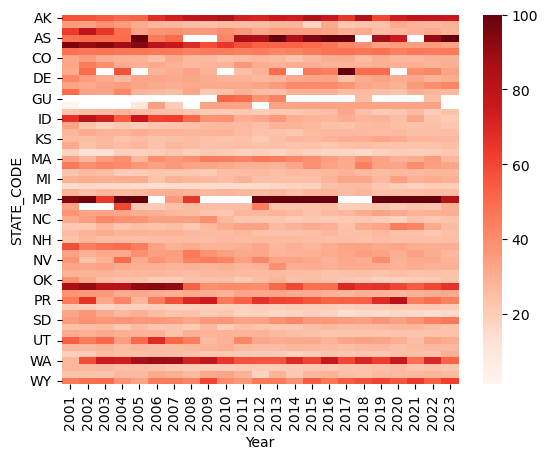

In [123]:
# percentage of violations resolved per year
heatmap_data = pws_viols_state_yrs.pivot(index='STATE_CODE', columns='Year', values='per_viols_res')
sns.heatmap(heatmap_data, cmap='Reds')

In [124]:
# some are high, some are low, not much change over time for most
# a few states are bimodal; that seems interesting

<Axes: xlabel='Year', ylabel='STATE_CODE'>

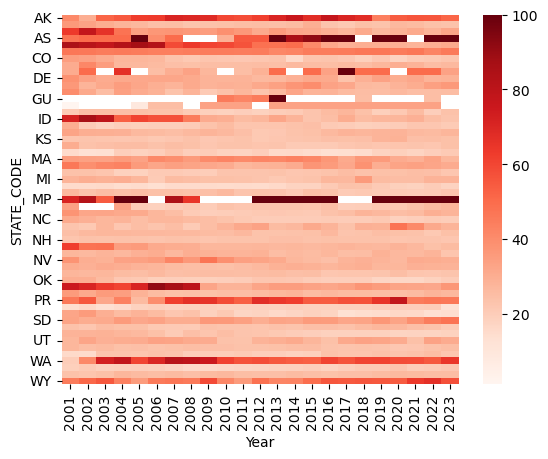

In [125]:
# percentage of health-based violations resolved per year
heatmap_data = pws_viols_state_yrs.pivot(index='STATE_CODE', columns='Year', values='per_viols_h_res')
sns.heatmap(heatmap_data, cmap='Reds')

In [126]:
# quite similar to previous

In [127]:
# Are there any big trends over time, and are there any spatial patterns to where they occur?

In [128]:
# create a new df of states with change in time for each stat

# Guam is missing 2001 data; edit the state list; can go back later and find start year and caveat the dataset if desired
states = list(pws_viols_state_yrs['STATE_CODE'].unique())
states.remove('GU')

# Hawaii is missing 2023 data; edit the state list; can go back later and find end year and caveat the dataset if desired
states.remove('HI')

#states

In [129]:
# define a function to calculate the change over time
def change_over_time(state, var):
    end = float(pws_viols_state_yrs[(pws_viols_state_yrs['STATE_CODE']==state) & (pws_viols_state_yrs['Year']==2023)][var].iloc[0])
    start = float(pws_viols_state_yrs[(pws_viols_state_yrs['STATE_CODE']==state) & (pws_viols_state_yrs['Year']==2001)][var].iloc[0])
    change = end - start
    #per_change = ((end - start)/start)*100
    return change

In [130]:
# loop through the states and create a list of values
# violations per pws
var = 'num_viols_pws'
num_viols_pws_change = [change_over_time(state, var) for state in states]

# number of health-based violations per pws
var = 'num_viols_h_pws'
num_viols_pws_h_change = [change_over_time(state, var) for state in states]

# duration of non-compliance
var = 'avg_non_compl_dur'
avg_non_compl_dur_change = [change_over_time(state, var) for state in states]

# percentage of violations resolving
var = 'per_viols_res'
per_viols_res_change = [change_over_time(state, var) for state in states]

# percentage of health-based violations resolving
var = 'per_viols_h_res'
per_viols_h_res_change = [change_over_time(state, var) for state in states]

In [131]:
# create a df
df_data = {'STATE_CODE': states,
           'num_viols_pws_change':num_viols_pws_change, 
           'num_viols_pws_h_change':num_viols_pws_h_change, 
           'avg_non_compl_dur_change':avg_non_compl_dur_change, 
           'per_viols_res_change':per_viols_res_change, 
           'per_viols_h_res_change':per_viols_h_res_change}
viols_pws_change = pd.DataFrame(df_data)

In [132]:
viols_pws_change

,STATE_CODE,num_viols_pws_change,num_viols_pws_h_change,avg_non_compl_dur_change,per_viols_res_change,per_viols_h_res_change
0,AK,0.812204,0.227249,-34.0,18.798570,10.325675
1,AL,0.043367,0.020408,-44.0,-6.900726,-12.493181
2,AR,0.130653,0.041709,31.0,-35.195358,-31.324189
3,AS,0.685185,-0.296296,229.0,52.000000,52.173913
4,AZ,-0.230153,0.075018,-145.0,-62.317148,-53.828312
5,CA,-0.094804,-0.064739,-154.0,-3.182681,-0.935071
6,CO,1.080672,0.228151,-138.0,-3.337768,-11.886219
7,CT,-0.163139,-0.106934,-94.0,-1.981402,-4.303955
8,DC,-0.259259,-0.370370,-671.0,1.754386,2.564103
9,DE,-0.070840,-0.074135,-55.0,-10.486443,-9.784736


In [133]:
# map the change variables

In [134]:
# join the stats to the state boundary spatial data
state_bds = state_bds.merge(viols_pws_change, on='STATE_CODE')

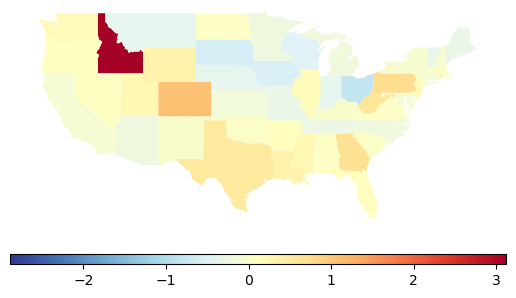

In [135]:
# number of violations per pws
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='num_viols_pws_change', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'},
    cmap='RdYlBu_r'
)

ax.set_axis_off()
#plt.title('Change in Number of Violations Per PWS (2001-2023)')
#plt.savefig('num_viols_pws_change_map.png', bbox_inches='tight')
plt.show()

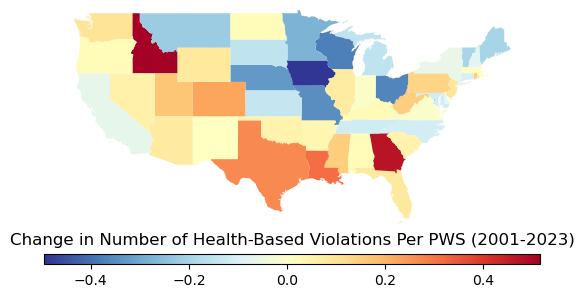

In [136]:
# number of health-based violations per pws
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='num_viols_pws_h_change', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'},
    cmap='RdYlBu_r'
)

ax.set_axis_off()
plt.title('Change in Number of Health-Based Violations Per PWS (2001-2023)')
#plt.savefig('num_viols_pws_h_change_map.png', bbox_inches='tight')
plt.show()

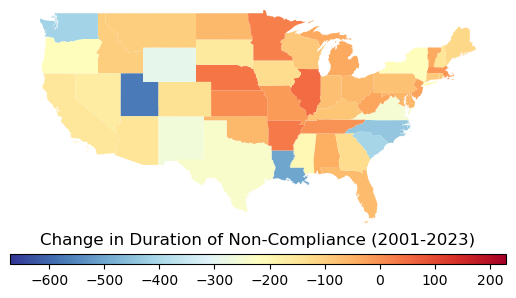

In [137]:
# duration of non-compliance
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='avg_non_compl_dur_change', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'},
    cmap='RdYlBu_r'
)

ax.set_axis_off()
plt.title('Change in Duration of Non-Compliance (2001-2023)')
#plt.savefig('avg_non_compl_dur_change_map.png', bbox_inches='tight')
plt.show()

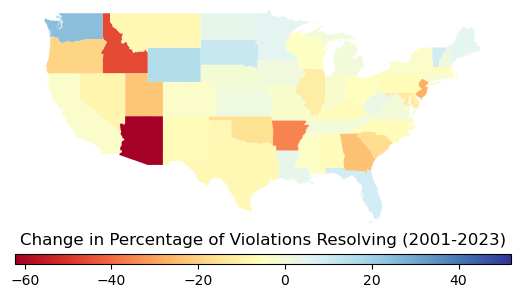

In [138]:
# percentage of violations resolving
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='per_viols_res_change', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'},
    cmap='RdYlBu'
)

ax.set_axis_off()
plt.title('Change in Percentage of Violations Resolving (2001-2023)')
#plt.savefig('per_viols_res_change_map.png', bbox_inches='tight')
plt.show()

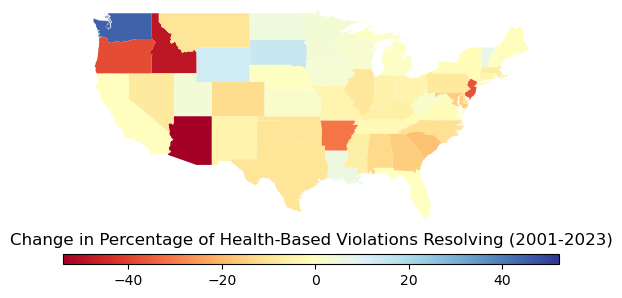

In [139]:
# percentage of health-based violations resolving
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='per_viols_h_res_change', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'},
    cmap='RdYlBu'
)

ax.set_axis_off()
plt.title('Change in Percentage of Health-Based Violations Resolving (2001-2023)')
#plt.savefig('per_viols_h_res_change_map.png', bbox_inches='tight')
plt.show()

# Site Visit Analysis

## Prep the site visit data

In [140]:
# Load site visit data
file = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\sdwa\SDWA_latest_downloads\SDWA_SITE_VISITS.csv"
visits = pd.read_csv(file)
# look at data fields
visits.columns

C:\Users\jenni\AppData\Local\Temp\ipykernel_30104\1082014287.py:3: DtypeWarning: Columns (8,10,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  visits = pd.read_csv(file)


Index(['SUBMISSIONYEARQUARTER', 'PWSID', 'VISIT_ID', 'VISIT_DATE',
       'AGENCY_TYPE_CODE', 'VISIT_REASON_CODE', 'MANAGEMENT_OPS_EVAL_CODE',
       'SOURCE_WATER_EVAL_CODE', 'SECURITY_EVAL_CODE', 'PUMPS_EVAL_CODE',
       'OTHER_EVAL_CODE', 'COMPLIANCE_EVAL_CODE',
       'DATA_VERIFICATION_EVAL_CODE', 'TREATMENT_EVAL_CODE',
       'FINISHED_WATER_STOR_EVAL_CODE', 'DISTRIBUTION_EVAL_CODE',
       'FINANCIAL_EVAL_CODE', 'VISIT_COMMENTS', 'FIRST_REPORTED_DATE',
       'LAST_REPORTED_DATE'],
      dtype='object')

In [141]:
# Map the visit reason codes 
reasons = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='VISIT_REASON_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
visits['VISIT_REASON_CODE'] = visits['VISIT_REASON_CODE'].astype(str).map(reasons)

# Map some other codes that aren't in the csv
# Map evaluation results categories
eval_results_dict = {'M':'Minor deficiencies',
                     'N':'No deficiencies or recommendations',
                     'R':'Recommendations made',
                     'S':'Significant deficiencies',
                     'X':'Not evaluated',
                     'Z':'Not applicable',
                     'D':'Sanitary defect'
                    }

evals = ['MANAGEMENT_OPS_EVAL_CODE', 'SOURCE_WATER_EVAL_CODE', 'SECURITY_EVAL_CODE', 'PUMPS_EVAL_CODE',
         'OTHER_EVAL_CODE', 'COMPLIANCE_EVAL_CODE', 'DATA_VERIFICATION_EVAL_CODE', 'TREATMENT_EVAL_CODE',
         'FINISHED_WATER_STOR_EVAL_CODE', 'DISTRIBUTION_EVAL_CODE', 'FINANCIAL_EVAL_CODE']

for eval in evals:
    visits[eval] = visits[eval].astype(str).map(eval_results_dict)

# Map agencies
agency_dict = {'NULL':'Unknown Agency Type','AR':'Alaskan Remote Village','AT':'Authority','BR':'Borough',
               'CM':'Commission','CN':'County','CT':'City','DS':'District','FD':'Federal','MN':'Municipality',
               'NA':'Native American Tribe','PR':'Parish','RG':'Region','SA':'State Administrative District',
               'SD':'School District','SR':'State Administrative Region','ST':'State','TW':'Town','WD':'Water District',
               'SC':'State Contractor','TA':'Non-State Provider Engineering/Technical Assistance Firm','WS':'Water System'
              }
visits['AGENCY_TYPE_CODE'] = visits['AGENCY_TYPE_CODE'].astype(str).map(agency_dict)


In [142]:
# Join the visits data to the filtered PWS df
pws_visits = sdwa_pws_active.merge(visits, on='PWSID')

# convert VISIT_DATE to datetime 
pws_visits['VISIT_DATE'] = pd.to_datetime(pws_visits['VISIT_DATE'], format='mixed')

# Filter visits to those occurring from 2001-2023
pws_visits = pws_visits[(pws_visits['VISIT_DATE']>'12-31-2000') & (pws_visits['VISIT_DATE']<'01-01-2024')]

# Add a column to record the site visit date year value only
pws_visits['Year'] = pws_visits['VISIT_DATE'].dt.year
pws_visits['Year'] = pws_visits['Year'].astype(int)

print(f'There were {len(pws_visits)} site visits at {len(pws_visits['PWSID'].unique())} water systemsfrom 2000-2023')

There were 1381784 site visits at 140264 water systemsfrom 2000-2023


## Number of Site Visits Per Year

In [143]:
# Count site visits per year by PWS type
# This is one place where there seemed to be a notable difference between CWS and other system types
# create a df of site visit counts grouped by year and system type
visits_by_year = pd.DataFrame(pws_visits.groupby(['Year','PWS_TYPE_CODE']).count().rename(columns={'VISIT_ID':'num_visits'})['num_visits'])

In [144]:
# Format site visits per year for stacked bar chart
years = range(2001,2024)
visit_counts = {'CWS':[], 'NTNCWS':[], 'TNCWS':[]}

# loop through the years
for year in years:
    # append visit counts to corresponding lists
    visit_counts['CWS'].append(int(visits_by_year.loc[year,'CWS'].iloc[0]))
    visit_counts['NTNCWS'].append(int(visits_by_year.loc[year,'NTNCWS'].iloc[0]))
    visit_counts['TNCWS'].append(int(visits_by_year.loc[year,'TNCWS'].iloc[0]))

# convert lists to np arrays
visit_counts['CWS'] = np.array(visit_counts['CWS'])
visit_counts['NTNCWS'] = np.array(visit_counts['NTNCWS'])
visit_counts['TNCWS'] = np.array(visit_counts['TNCWS'])

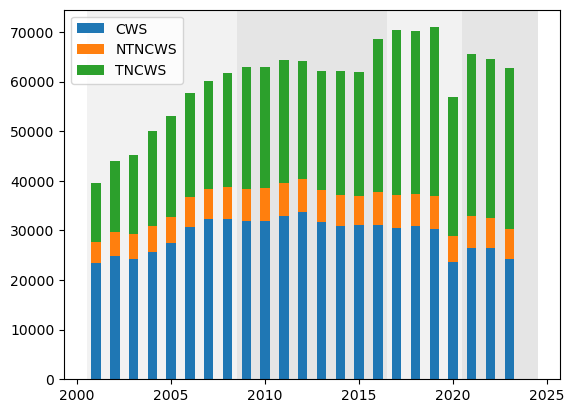

In [145]:
# plot the data
width = 0.5

plt.bar(years, visit_counts['CWS'], width, label='CWS')
plt.bar(years, visit_counts['NTNCWS'], width, bottom=visit_counts['CWS'], label='NTNCWS')
plt.bar(years, visit_counts['TNCWS'], width, bottom=visit_counts['CWS']+visit_counts['NTNCWS'], label='TNCWS')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

#ax.set_title("Number Of Site Visits By System Type")
plt.legend(bbox_to_anchor=(0,1), loc='upper left')

#plt.savefig('num_visits_type.png', bbox_inches='tight')
plt.show()

In [146]:
# add the total number of visits per year
total_visits = pd.DataFrame(pws_visits.groupby('Year').count().rename(columns={'VISIT_ID':'num_visits'})['num_visits'])
total_visits['PWS_TYPE_CODE'] = 'Annual Total'
total_visits = total_visits.reset_index().set_index(['Year','PWS_TYPE_CODE'])
visits_with_tot = pd.concat([visits_by_year,total_visits])

Text(20.347222222222214, 0.5, 'Number of Site Visits')

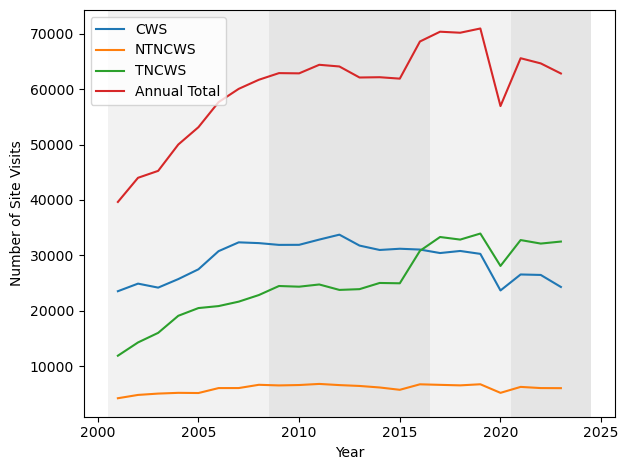

In [147]:
# make a plot of site visits by year with total
sns.lineplot(data=visits_with_tot, x='Year', y='num_visits', hue='PWS_TYPE_CODE')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.legend(bbox_to_anchor=(0,1), loc='upper left')
plt.ylabel('Number of Site Visits')
#plt.savefig('num_visits_by_year.png')

## What percentage of each site type gets a visit each year?

**NOTE**: This is actually a calculation of the number of visits divided by the number of systems of that type.

It would be better to count the number of PWS and divide it by the number of systems of that type.

In [148]:
# create a df of visits by type and year
per_visits_year = pws_visits.groupby(['Year','PWS_TYPE_CODE']).count().reset_index().rename(columns={'VISIT_ID':'num_visits'})[['Year','PWS_TYPE_CODE','num_visits']]
# add a column 
per_visits_year['per_visits'] = per_visits_year.apply(lambda x: (x['num_visits'] / int(sdwa_pws_active['PWS_TYPE_CODE'].value_counts()[x['PWS_TYPE_CODE']])*100), axis=1)

Text(46.972222222222214, 0.5, 'Percentage of Site With Visits')

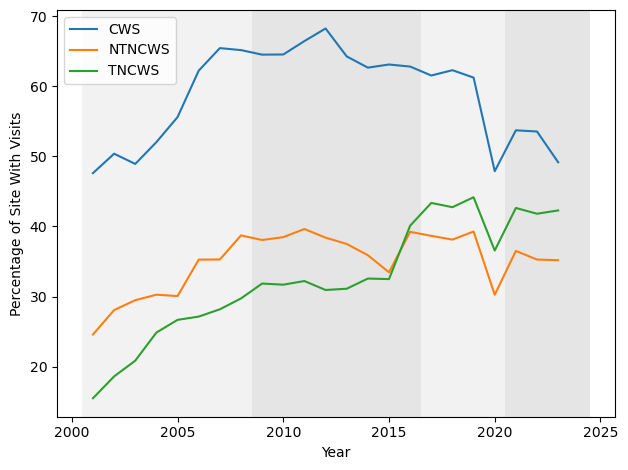

In [149]:
# plot the percentage data
sns.lineplot(data=per_visits_year, x='Year', y='per_visits', hue='PWS_TYPE_CODE')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.legend(bbox_to_anchor=(0,1), loc='upper left')
plt.ylabel('Percentage of Site With Visits')
#plt.savefig('per_visits_by_year.png')

## What types of visits are these? 

Look at Type of Visits by Year

In [150]:
# group visits by type and year
pws_visits_type = pws_visits.groupby(['Year', 'VISIT_REASON_CODE'], as_index=False).count().rename(columns={'VISIT_ID':'num_visits'})[['Year', 'VISIT_REASON_CODE', 'num_visits']]

Text(0, 0.5, 'Number of Visits By Type')

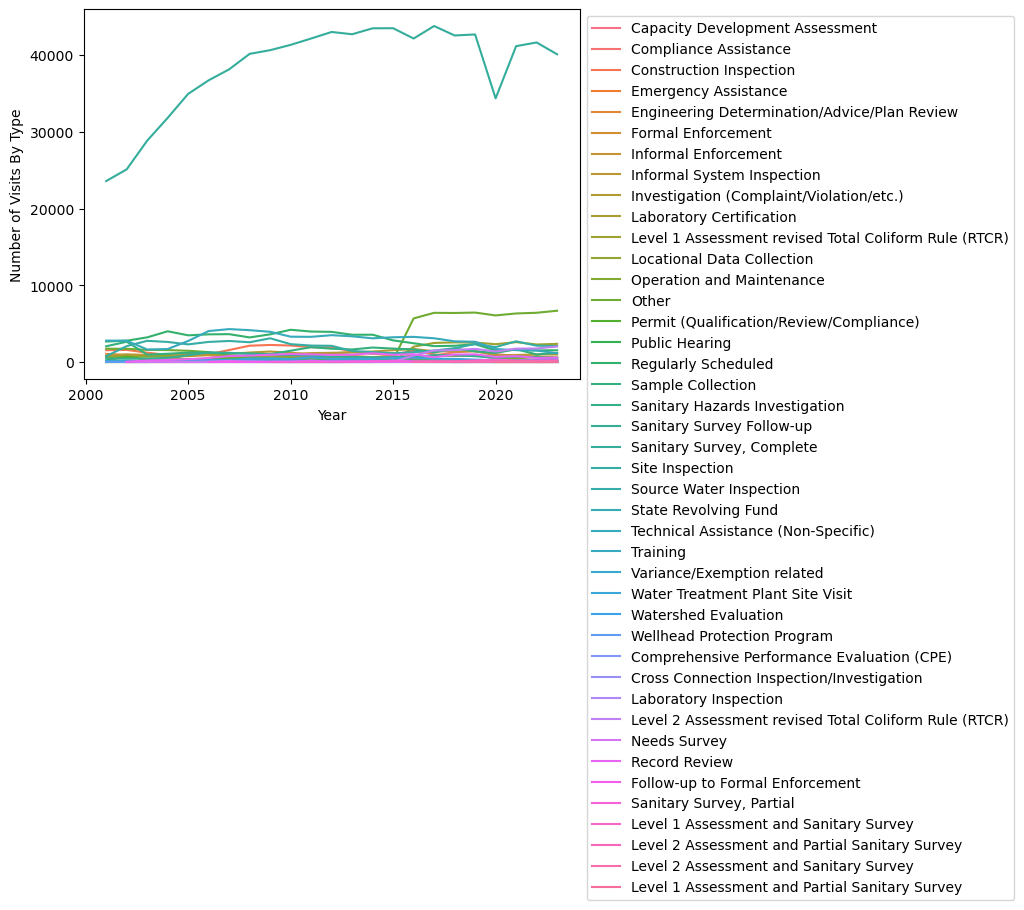

In [151]:
# take a look at the counts over time
sns.lineplot(data=pws_visits_type, x='Year', y='num_visits', hue='VISIT_REASON_CODE')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Number of Visits By Type')

In [152]:
# So many types. One of them is much more common. 
pws_visits_type[pws_visits_type['num_visits'] == pws_visits_type['num_visits'].max()]

,Year,VISIT_REASON_CODE,num_visits
590,2017,"Sanitary Survey, Complete",43786


In [153]:
# Sanitary surveys are more common than any other kind of visit

In [154]:
# Whats the type that becomes a little bit more common than the others around 2016?
pws_visits_type[pws_visits_type['Year']==2018].sort_values(by='num_visits',ascending=False).head(2)

,Year,VISIT_REASON_CODE,num_visits
629,2018,"Sanitary Survey, Complete",42554
621,2018,Other,6392


In [155]:
# 'Other' is not super informative

In [156]:
# Who performed the sanitary survey visits?
pws_visits[pws_visits['VISIT_REASON_CODE']=='Sanitary Survey, Complete'][['AGENCY_TYPE_CODE']].apply(pd.Series.value_counts)

,AGENCY_TYPE_CODE
AGENCY_TYPE_CODE,
State,664674
County,117561
District,59263
State Administrative District,14359
State Administrative Region,13334
Region,6918
Federal,292
School District,18
Commission,6


In [157]:
# Who performed the visits in general?
pws_visits.groupby('AGENCY_TYPE_CODE').count()['VISIT_ID'].sort_values(ascending=False)

AGENCY_TYPE_CODE
State                            1032273
County                            190448
District                           81164
State Administrative District      27216
State Administrative Region        22384
Region                              7904
Water System                        2439
Water District                       324
Federal                              303
School District                       18
Commission                             6
Name: VISIT_ID, dtype: int64

In [158]:
# 1. Local authorities, particularly states, do the visits. Makes total sense.
# 2. The number of federal visits is *extremely* low.

### What were the outcomes of the sanitary visits?

Take sanitary survey visits as a subset since they were so much more common that other categories

In [159]:
# Filter for sanitary survey visits (most common type) and outcome categories
outcomes_sanitary = pws_visits[pws_visits['VISIT_REASON_CODE']=='Sanitary Survey, Complete'][['MANAGEMENT_OPS_EVAL_CODE', 'SOURCE_WATER_EVAL_CODE',
                                                                          'SECURITY_EVAL_CODE', 'PUMPS_EVAL_CODE', 'OTHER_EVAL_CODE',
                                                                          'COMPLIANCE_EVAL_CODE', 'DATA_VERIFICATION_EVAL_CODE',
                                                                          'TREATMENT_EVAL_CODE', 'FINISHED_WATER_STOR_EVAL_CODE',
                                                                          'DISTRIBUTION_EVAL_CODE', 'FINANCIAL_EVAL_CODE']].apply(pd.Series.value_counts)
# a bit hard to make sense of as raw numbers instead of percentages, 
for col in outcomes_sanitary.columns:
    outcomes_sanitary[col] = (outcomes_sanitary[col] / outcomes_sanitary[col].sum()) * 100  


In [160]:
# check the math
outcomes_sanitary.sum() 

MANAGEMENT_OPS_EVAL_CODE         100.0
SOURCE_WATER_EVAL_CODE           100.0
SECURITY_EVAL_CODE               100.0
PUMPS_EVAL_CODE                  100.0
OTHER_EVAL_CODE                  100.0
COMPLIANCE_EVAL_CODE             100.0
DATA_VERIFICATION_EVAL_CODE      100.0
TREATMENT_EVAL_CODE              100.0
FINISHED_WATER_STOR_EVAL_CODE    100.0
DISTRIBUTION_EVAL_CODE           100.0
FINANCIAL_EVAL_CODE              100.0
dtype: float64

In [161]:
outcomes_sanitary # of sanitary survey visits

,MANAGEMENT_OPS_EVAL_CODE,SOURCE_WATER_EVAL_CODE,SECURITY_EVAL_CODE,PUMPS_EVAL_CODE,OTHER_EVAL_CODE,COMPLIANCE_EVAL_CODE,DATA_VERIFICATION_EVAL_CODE,TREATMENT_EVAL_CODE,FINISHED_WATER_STOR_EVAL_CODE,DISTRIBUTION_EVAL_CODE,FINANCIAL_EVAL_CODE
Minor deficiencies,7.374935,8.762107,1.707998,1.892203,0.460541,1.299022,5.032319,5.205041,4.184012,5.623055,0.131516
No deficiencies or recommendations,64.001204,61.401035,66.878904,70.663525,40.820406,70.049765,70.142407,62.279012,66.216933,67.855355,58.482054
Not applicable,3.617481,3.111677,18.708947,9.083892,31.084784,10.755373,4.003657,10.899596,7.919157,4.705865,21.690795
Not evaluated,12.709122,12.801190,9.323962,14.886335,25.493702,13.808687,13.451767,13.560997,13.567715,12.808703,17.919870
Recommendations made,10.087055,10.267765,3.020832,3.056961,1.715288,3.158767,5.655537,6.014245,6.249319,7.298253,1.749906
Sanitary defect,0.000248,0.011399,0.000212,0.000124,0.000165,NaN,0.000124,0.001735,0.001487,0.001982,NaN
Significant deficiencies,2.209954,3.644827,0.359144,0.416960,0.425115,0.928386,1.714189,2.039374,1.861378,1.706787,0.025859


Text(0, 0.5, 'Outcomes of Sanitary Survey Visits')

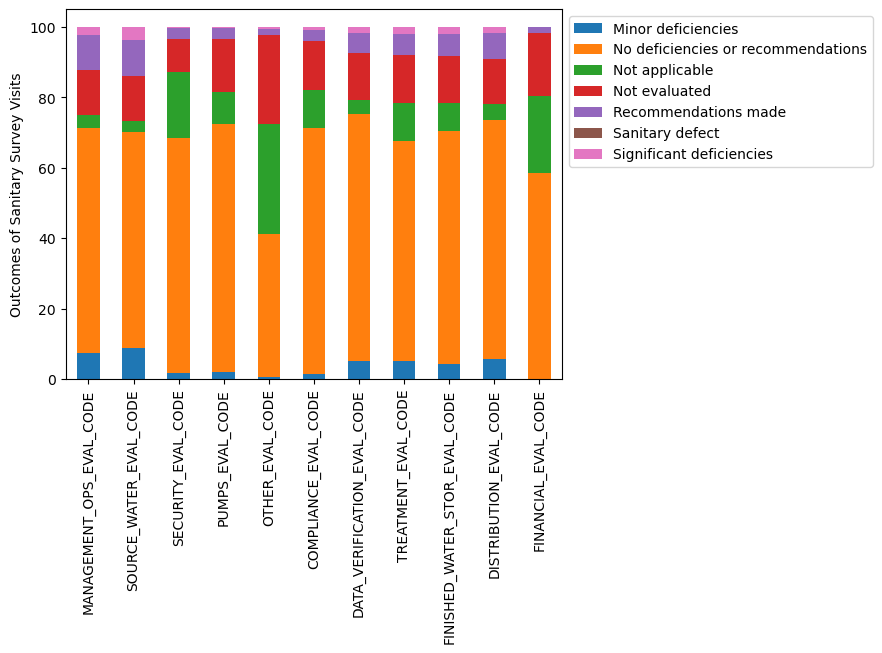

In [162]:
outcomes_sanitary.transpose().plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Outcomes of Sanitary Survey Visits')
#plt.savefig('san_visit_outcomes.png', bbox_inches='tight')

### What types of inspections did the federal government do? What were the outcomes?

In [163]:
# filter the visits df for federal only
pws_visits_federal = pws_visits[pws_visits['AGENCY_TYPE_CODE']=='Federal']

In [164]:
# number of visits by year
pws_visits_federal.groupby('Year').count().rename(columns={'VISIT_ID':'num_visits'})['num_visits']

Year
2001     9
2002     4
2003    28
2004     4
2005     1
2006    36
2007    44
2008    24
2009    18
2010     4
2011     3
2012    25
2013     1
2014     2
2015    25
2016     8
2017     1
2018    22
2019     6
2020     3
2021    28
2022     4
2023     3
Name: num_visits, dtype: int64

In [165]:
# They seem to go on a three year cycle; plus 2007 & 2008

In [166]:
# Filter for federal visits and outcome categories
outcomes_federal = pws_visits_federal[['MANAGEMENT_OPS_EVAL_CODE', 'SOURCE_WATER_EVAL_CODE', 'SECURITY_EVAL_CODE', 'PUMPS_EVAL_CODE', 
                                       'OTHER_EVAL_CODE', 'COMPLIANCE_EVAL_CODE', 'DATA_VERIFICATION_EVAL_CODE', 'TREATMENT_EVAL_CODE', 
                                       'FINISHED_WATER_STOR_EVAL_CODE', 'DISTRIBUTION_EVAL_CODE', 'FINANCIAL_EVAL_CODE']].apply(pd.Series.value_counts)
# calculate as percentages
for col in outcomes_federal.columns:
    outcomes_federal[col] = (outcomes_federal[col] / outcomes_federal[col].sum()) * 100  


Text(0, 0.5, 'Outcomes of Federal Site Visits')

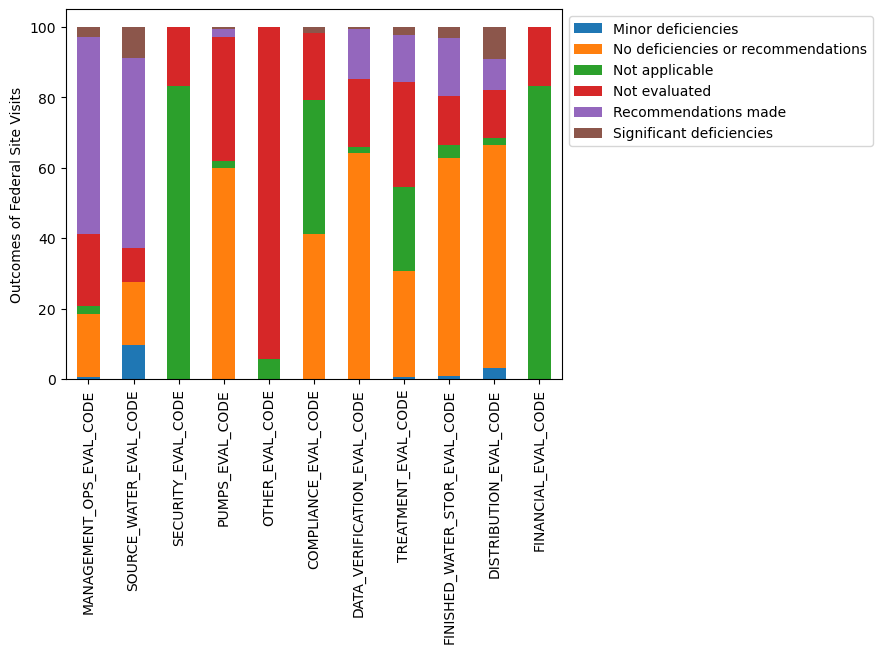

In [167]:
# plot the outcomes by evaluation type, over the entire time frame
outcomes_federal.transpose().plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Outcomes of Federal Site Visits')

In [168]:
# It might be more interesting to look at these federal visits in another way.